In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import scipy
import importlib
import os, sys
import seaborn as sns
import tqdm
# from pandas_datareader import data
import networkx as nx
sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
sys.path.insert(0, 'C:/Users/ragna/Documents/Code/MMDGraph')

import graph_fun as gf
import importlib


#from rpy2.robjects.packages import importr
#import rpy2.robjects as ro
#import rpy2.robjects.numpy2ri
#from rpy2.robjects import pandas2ri
#rpy2.robjects.numpy2ri.activate()

from sklearn.covariance import graphical_lasso, GraphicalLasso, GraphicalLassoCV

from myKernels import RandomWalk as rw
from myKernels import WWL
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])
import grakel as gk

from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

import warnings


Define function

In [2]:
def glasso_grid_search(S, alphas, max_iter = 1000):
    """
    Define a grid search function for Friedman glasso algorithm
    """

    costs = []
    for alpha in alphas:
        try:
            out = graphical_lasso(S, alpha = alpha, max_iter=max_iter, return_costs = True)
            if isinstance(out[2], list):
                costs.append(out[2][-1][0])
            else:
                costs.append(out[2][0])
        except FloatingPointError:
            costs.append(np.nan)
        except Warning:
            costs.append(np.nan)

    costs = np.array(costs)
    best_alpha_index = np.where(costs == np.nanmin(costs))

    out = graphical_lasso(S, alpha = alphas[best_alpha_index], max_iter=max_iter, return_costs = True)
    return out[1], costs

# Read Data

In [3]:
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
esg_refined = pd.read_pickle('../Yahoo/refined_no_diff.pkl')
 


price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > datetime.datetime(2014,9, 1), price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


adjclose_pivot = price_filtered[['ticker', 'adjclose', 'date']].copy() 
adjclose_pivot = adjclose_pivot.dropna()  # Drop rows which contain missing values
adjclose_pivot = pd.pivot_table(adjclose_pivot, values = 'adjclose', index = 'date', columns= 'ticker')

price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
price_pivot.shape

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
price_pivot = price_pivot.iloc[:, company_df['track_index']]

esg_refined = pd.read_pickle('../Yahoo/refined_no_diff.pkl')



asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

sector_classification = dict()
for company in asset_profiles['ticker']:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)


price_pivot = price_pivot.dropna(axis = 1)


<AxesSubplot:xlabel='date'>

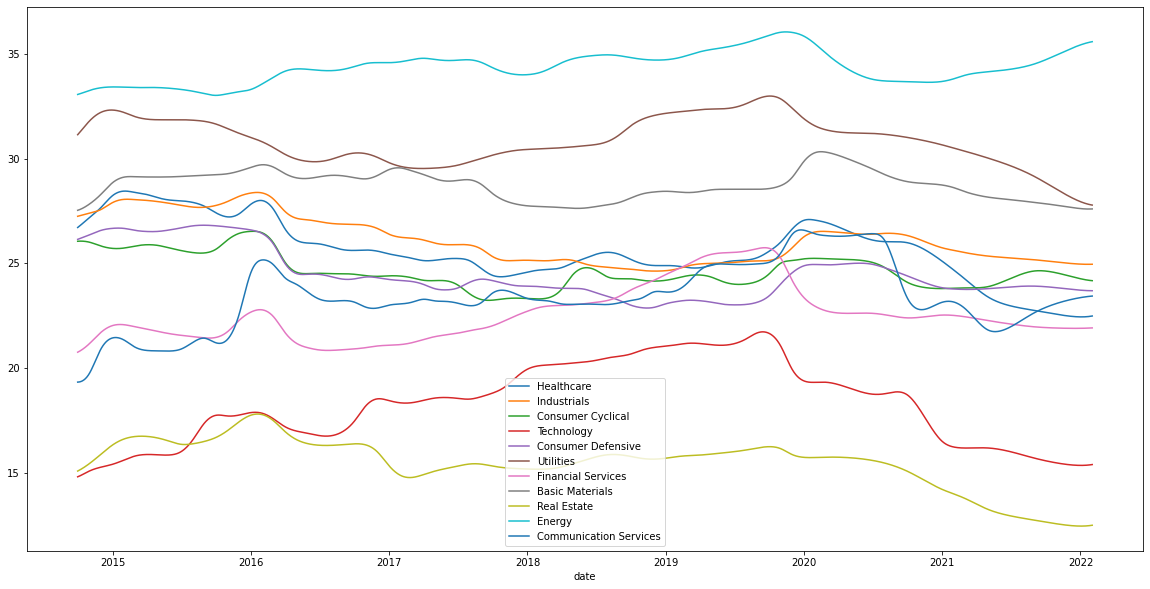

In [4]:
sector_gp = pd.read_pickle('../data/paper/sector_gp.pkl')
sector_gp.plot(figsize = (20,10))

<AxesSubplot:xlabel='date'>

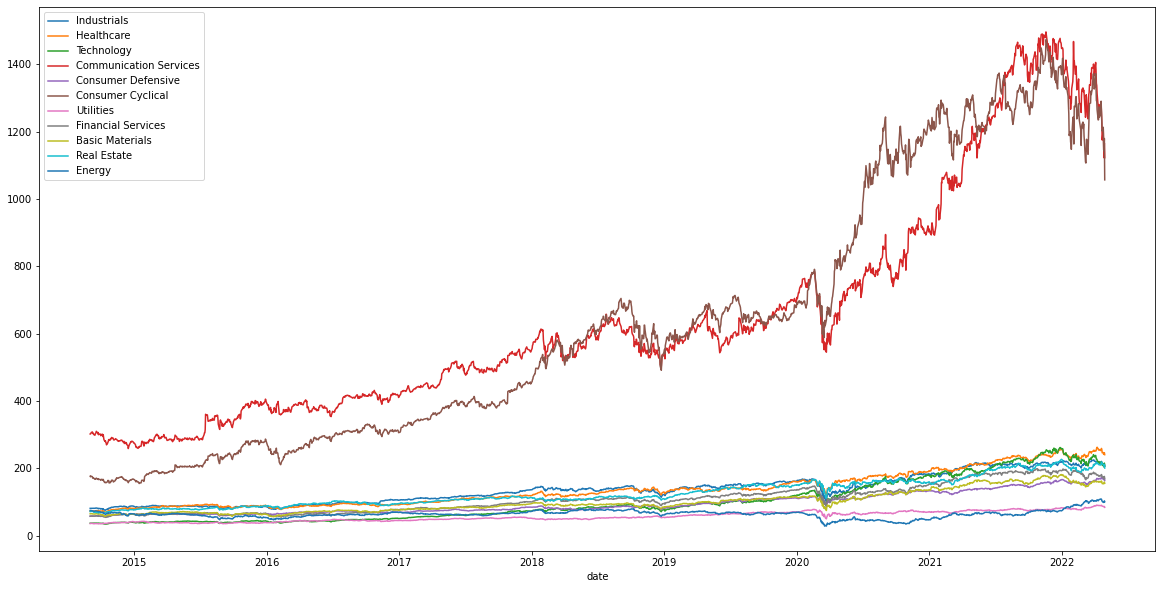

In [5]:
# with open('../Yahoo/sector_index_price.pkl', 'wb') as handle:
#     pickle.dump(sector_price_index, handle)

price_sector = pd.read_pickle('../data/paper/sector_index_price.pkl')
price_sector.plot(figsize = (20,10))

# Sector ESG  lasso

Take ESG before and after intervention

In [5]:
after_shock = sector_gp.loc[sector_gp.index >= datetime.date(2020,1,1)]
before_shock = sector_gp.loc[sector_gp.index <= datetime.date(2019,10,1)]  # Not all scores change on same date, leave some margin
before_shock = before_shock.iloc[-after_shock.shape[0]:]
before_shock.shape == after_shock.shape

True

In [6]:

alphas = np.linspace(0,1, 50)
scaler = StandardScaler()
X = scaler.fit_transform(before_shock.iloc[0:(125+0)])
out_esg_test = GraphicalLassoCV(cv = 3, alphas= list(alphas)).fit(X)
# plt.plot(out_esg_test.cv_results_['alphas'], out_esg_test.cv_results_['mean_score'])
out_esg_test.precision_

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([[ 2.57687175, -0.41491962, -0.        , -0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
         1.78321275],
       [-0.41491962,  3.03444225,  0.        ,  0.        , -0.        ,
         0.32976675,  0.        , -0.66558387, -0.60398475, -0.69422895,
         0.37759637],
       [-0.        ,  0.        ,  2.39548551, -0.17320421,  0.7094061 ,
        -0.20372827, -0.29900935,  0.14004074,  0.20538458,  0.31830004,
         0.        ],
       [-0.        ,  0.        , -0.17320421,  2.96906626,  0.58920473,
        -0.41394001, -1.1528451 ,  0.15173326,  0.18427594,  0.04966183,
         0.06557653],
       [ 0.        , -0.        ,  0.7094061 ,  0.58920473,  3.8510579 ,
         0.51143399,  0.57780976, -0.46889832, -0.4762907 , -0.49125694,
        -0.        ],
       [ 0.        ,  0.32976675, -0.20372827, -0.41394001,  0.51143399,
         3.83564734, -0.47312702,  0.63089162,  0.61755998,  0.6094353 ,
        -0.   

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(sector_gp.iloc[1570:(125+1570)])
out_esg_glasso = GraphicalLassoCV(cv = 3, alphas = list(alphas)).fit(X)

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [9]:
is_all_pos_vec = []
nr_pos = []
nr_neg = []
dates = []
N = 125

G_prec = [] # all correlation graph
G_pos = [] # only positve correlation weighted
G_neg = [] # only negative correlation weighted
G_signed = [] # Sign

alphas = []
scores = []

warnings.filterwarnings("ignore")
for i in tqdm.tqdm(range(0, sector_gp.shape[0]-N,5)):

    calculation_bad = True
    start_alpha = 0
    alphas_cv = list(np.linspace(start_alpha,1,100))
    
    while calculation_bad:

        names = {k:j for k, j in enumerate(sector_gp.columns)}
        #S = np.array(sector_gp.iloc[i:(N+i)].corr())
        scaler = StandardScaler()
        X = scaler.fit_transform(sector_gp.iloc[i:(N+i)])

        #prec, costs = glasso_grid_search(S, alphas, max_iter=100)

        try:
            out_esg_glasso = GraphicalLassoCV(cv = 3, alphas=alphas_cv).fit(X)
        except:
            # print(f'{i} {sector_gp.index[N+i]} failed ')
            calculation_bad = True
            start_alpha += 0.01
            alphas_cv = list(np.linspace(start_alpha,1,100))
            print(f'{i} {sector_gp.index[N+i]} failed {start_alpha} ')
            continue
        calculation_bad = False
        alphas.append(out_esg_glasso.cv_results_['alphas'])
        scores.append(out_esg_glasso.cv_results_['mean_score'])

        prec = -out_esg_glasso.precision_

        if np.max(np.abs(prec)) > 10:
            calculation_bad = True
            start_alpha += 0.01
            alphas_cv = list(np.linspace(start_alpha,1,100))
            print(f'{i} {sector_gp.index[N+i]} failed, too high precision {start_alpha} ')
            continue




        # All edges
        G = nx.from_numpy_array(prec)
        nx.set_node_attributes(G, names, "label")
        G_prec.append(G)
        # positive edges
        prec_pos = prec.copy()
        prec_pos[prec_pos <0] = 0
        G = nx.from_numpy_array(prec_pos)
        nx.set_node_attributes(G, names, "label")
        G_pos.append(G)
        # negative edges
        prec_neg = prec.copy()
        prec_neg[prec_neg >0] = 0
        G = nx.from_numpy_array(np.abs(prec_neg))
        nx.set_node_attributes(G, names, "label")
        G_neg.append(G)
        # signed
        G = nx.from_numpy_array(prec)
        nx.set_edge_attributes(G, {(n1, n2): np.sign(val) for n1, n2, val in G.edges.data('weight')}, "sign")
        nx.set_node_attributes(G, names, "label")
        G_signed.append(G)

        dates.append(sector_gp.index[N+i])

dates = np.array(dates)

warnings.filterwarnings("default")

  0%|          | 0/512 [00:00<?, ?it/s]

0 2015-02-03 failed, too high precision 0.01 
0 2015-02-03 failed, too high precision 0.02 


  0%|          | 1/512 [00:02<23:59,  2.82s/it]

5 2015-02-08 failed, too high precision 0.01 
5 2015-02-08 failed, too high precision 0.02 
5 2015-02-08 failed, too high precision 0.03 
5 2015-02-08 failed, too high precision 0.04 


  0%|          | 2/512 [00:07<31:16,  3.68s/it]

10 2015-02-13 failed, too high precision 0.01 
10 2015-02-13 failed, too high precision 0.02 
10 2015-02-13 failed, too high precision 0.03 
10 2015-02-13 failed, too high precision 0.04 
10 2015-02-13 failed, too high precision 0.05 


  2%|▏         | 8/512 [00:15<09:08,  1.09s/it]

40 2015-03-15 failed, too high precision 0.01 
40 2015-03-15 failed, too high precision 0.02 
40 2015-03-15 failed, too high precision 0.03 
40 2015-03-15 failed, too high precision 0.04 
40 2015-03-15 failed, too high precision 0.05 
40 2015-03-15 failed, too high precision 0.060000000000000005 


  4%|▎         | 18/512 [00:27<06:40,  1.23it/s]

90 2015-05-04 failed, too high precision 0.01 
90 2015-05-04 failed, too high precision 0.02 
90 2015-05-04 failed, too high precision 0.03 
90 2015-05-04 failed, too high precision 0.04 
90 2015-05-04 failed, too high precision 0.05 


  5%|▌         | 28/512 [00:38<06:46,  1.19it/s]

140 2015-06-23 failed 0.01 


  7%|▋         | 36/512 [00:44<06:05,  1.30it/s]

180 2015-08-02 failed, too high precision 0.01 
180 2015-08-02 failed, too high precision 0.02 
180 2015-08-02 failed, too high precision 0.03 
180 2015-08-02 failed, too high precision 0.04 


  7%|▋         | 37/512 [00:48<13:15,  1.68s/it]

185 2015-08-07 failed, too high precision 0.01 
185 2015-08-07 failed, too high precision 0.02 
185 2015-08-07 failed, too high precision 0.03 
185 2015-08-07 failed, too high precision 0.04 


  7%|▋         | 38/512 [00:52<18:37,  2.36s/it]

190 2015-08-12 failed, too high precision 0.01 
190 2015-08-12 failed, too high precision 0.02 
190 2015-08-12 failed, too high precision 0.03 
190 2015-08-12 failed, too high precision 0.04 
190 2015-08-12 failed, too high precision 0.05 


  8%|▊         | 40/512 [00:58<19:04,  2.42s/it]

200 2015-08-22 failed, too high precision 0.01 
200 2015-08-22 failed, too high precision 0.02 
200 2015-08-22 failed, too high precision 0.03 
200 2015-08-22 failed, too high precision 0.04 


  8%|▊         | 41/512 [01:02<22:36,  2.88s/it]

205 2015-08-27 failed, too high precision 0.01 
205 2015-08-27 failed, too high precision 0.02 
205 2015-08-27 failed, too high precision 0.03 
205 2015-08-27 failed, too high precision 0.04 


  8%|▊         | 42/512 [01:06<25:12,  3.22s/it]

210 2015-09-01 failed, too high precision 0.01 
210 2015-09-01 failed, too high precision 0.02 
210 2015-09-01 failed, too high precision 0.03 


 13%|█▎        | 65/512 [01:25<05:45,  1.29it/s]

325 2015-12-25 failed, too high precision 0.01 


 13%|█▎        | 69/512 [01:29<05:56,  1.24it/s]

345 2016-01-14 failed, too high precision 0.01 
345 2016-01-14 failed, too high precision 0.02 


 15%|█▍        | 75/512 [01:35<06:07,  1.19it/s]

375 2016-02-13 failed, too high precision 0.01 


 16%|█▌        | 83/512 [01:41<05:26,  1.31it/s]

415 2016-03-24 failed, too high precision 0.01 


 16%|█▋        | 84/512 [01:43<07:13,  1.01s/it]

420 2016-03-29 failed, too high precision 0.01 


 17%|█▋        | 88/512 [01:46<05:52,  1.20it/s]

440 2016-04-18 failed, too high precision 0.01 


 17%|█▋        | 89/512 [01:48<07:13,  1.03s/it]

445 2016-04-23 failed, too high precision 0.01 
445 2016-04-23 failed, too high precision 0.02 
445 2016-04-23 failed, too high precision 0.03 
445 2016-04-23 failed, too high precision 0.04 
445 2016-04-23 failed, too high precision 0.05 


 18%|█▊        | 90/512 [01:52<14:59,  2.13s/it]

450 2016-04-28 failed, too high precision 0.01 
450 2016-04-28 failed, too high precision 0.02 
450 2016-04-28 failed, too high precision 0.03 
450 2016-04-28 failed, too high precision 0.04 
450 2016-04-28 failed, too high precision 0.05 


 18%|█▊        | 91/512 [01:57<20:48,  2.97s/it]

455 2016-05-03 failed, too high precision 0.01 
455 2016-05-03 failed, too high precision 0.02 
455 2016-05-03 failed, too high precision 0.03 
455 2016-05-03 failed, too high precision 0.04 


 18%|█▊        | 93/512 [02:02<17:45,  2.54s/it]

465 2016-05-13 failed, too high precision 0.01 
465 2016-05-13 failed, too high precision 0.02 
465 2016-05-13 failed, too high precision 0.03 


 18%|█▊        | 94/512 [02:05<19:06,  2.74s/it]

470 2016-05-18 failed, too high precision 0.01 
470 2016-05-18 failed, too high precision 0.02 
470 2016-05-18 failed, too high precision 0.03 


 19%|█▉        | 97/512 [02:10<12:00,  1.73s/it]

485 2016-06-02 failed, too high precision 0.01 
485 2016-06-02 failed, too high precision 0.02 


 19%|█▉        | 98/512 [02:12<13:25,  1.95s/it]

490 2016-06-07 failed, too high precision 0.01 
490 2016-06-07 failed, too high precision 0.02 


 19%|█▉        | 99/512 [02:15<14:21,  2.09s/it]

495 2016-06-12 failed, too high precision 0.01 
495 2016-06-12 failed, too high precision 0.02 
495 2016-06-12 failed, too high precision 0.03 
495 2016-06-12 failed, too high precision 0.04 


 20%|██        | 104/512 [02:21<07:59,  1.18s/it]

520 2016-07-07 failed, too high precision 0.01 
520 2016-07-07 failed, too high precision 0.02 
520 2016-07-07 failed, too high precision 0.03 
520 2016-07-07 failed, too high precision 0.04 
520 2016-07-07 failed, too high precision 0.05 


 21%|██        | 105/512 [02:26<15:41,  2.31s/it]

525 2016-07-12 failed, too high precision 0.01 
525 2016-07-12 failed, too high precision 0.02 
525 2016-07-12 failed, too high precision 0.03 
525 2016-07-12 failed, too high precision 0.04 
525 2016-07-12 failed, too high precision 0.05 


 21%|██        | 106/512 [02:31<21:08,  3.12s/it]

530 2016-07-17 failed, too high precision 0.01 
530 2016-07-17 failed, too high precision 0.02 
530 2016-07-17 failed, too high precision 0.03 
530 2016-07-17 failed, too high precision 0.04 
530 2016-07-17 failed, too high precision 0.05 
530 2016-07-17 failed, too high precision 0.060000000000000005 


 23%|██▎       | 120/512 [02:47<05:11,  1.26it/s]

600 2016-09-25 failed, too high precision 0.01 


 27%|██▋       | 136/512 [02:59<04:09,  1.50it/s]

680 2016-12-14 failed, too high precision 0.01 


 27%|██▋       | 139/512 [03:02<04:55,  1.26it/s]

695 2016-12-29 failed, too high precision 0.01 
695 2016-12-29 failed, too high precision 0.02 
695 2016-12-29 failed, too high precision 0.03 
695 2016-12-29 failed, too high precision 0.04 
695 2016-12-29 failed, too high precision 0.05 


 27%|██▋       | 140/512 [03:07<12:49,  2.07s/it]

700 2017-01-03 failed, too high precision 0.01 
700 2017-01-03 failed, too high precision 0.02 
700 2017-01-03 failed, too high precision 0.03 
700 2017-01-03 failed, too high precision 0.04 
700 2017-01-03 failed, too high precision 0.05 
700 2017-01-03 failed, too high precision 0.060000000000000005 


 28%|██▊       | 141/512 [03:13<20:08,  3.26s/it]

705 2017-01-08 failed, too high precision 0.01 
705 2017-01-08 failed, too high precision 0.02 
705 2017-01-08 failed, too high precision 0.03 
705 2017-01-08 failed, too high precision 0.04 
705 2017-01-08 failed, too high precision 0.05 
705 2017-01-08 failed, too high precision 0.060000000000000005 


 28%|██▊       | 142/512 [03:18<23:57,  3.88s/it]

710 2017-01-13 failed, too high precision 0.01 
710 2017-01-13 failed, too high precision 0.02 
710 2017-01-13 failed, too high precision 0.03 
710 2017-01-13 failed, too high precision 0.04 
710 2017-01-13 failed, too high precision 0.05 


 28%|██▊       | 143/512 [03:23<25:27,  4.14s/it]

715 2017-01-18 failed, too high precision 0.01 
715 2017-01-18 failed, too high precision 0.02 


 28%|██▊       | 144/512 [03:25<22:04,  3.60s/it]

720 2017-01-23 failed, too high precision 0.01 
720 2017-01-23 failed, too high precision 0.02 
720 2017-01-23 failed, too high precision 0.03 
720 2017-01-23 failed, too high precision 0.04 


 28%|██▊       | 145/512 [03:29<22:38,  3.70s/it]

725 2017-01-28 failed, too high precision 0.01 
725 2017-01-28 failed, too high precision 0.02 
725 2017-01-28 failed, too high precision 0.03 


 33%|███▎      | 168/512 [03:49<04:27,  1.29it/s]

840 2017-05-23 failed, too high precision 0.01 
840 2017-05-23 failed, too high precision 0.02 
840 2017-05-23 failed, too high precision 0.03 
840 2017-05-23 failed, too high precision 0.04 


 33%|███▎      | 171/512 [03:54<06:35,  1.16s/it]

855 2017-06-07 failed, too high precision 0.01 


 34%|███▎      | 172/512 [03:55<06:46,  1.20s/it]

860 2017-06-12 failed, too high precision 0.01 


 36%|███▌      | 182/512 [04:03<03:35,  1.53it/s]

910 2017-08-01 failed, too high precision 0.01 


 37%|███▋      | 189/512 [04:08<03:54,  1.38it/s]

945 2017-09-05 failed 0.01 


 38%|███▊      | 192/512 [04:11<04:07,  1.29it/s]

960 2017-09-20 failed, too high precision 0.01 


 38%|███▊      | 196/512 [04:14<04:16,  1.23it/s]

980 2017-10-10 failed, too high precision 0.01 
980 2017-10-10 failed, too high precision 0.02 
980 2017-10-10 failed, too high precision 0.03 
980 2017-10-10 failed, too high precision 0.04 
980 2017-10-10 failed, too high precision 0.05 
980 2017-10-10 failed, too high precision 0.060000000000000005 


 38%|███▊      | 197/512 [04:20<11:35,  2.21s/it]

985 2017-10-15 failed, too high precision 0.01 
985 2017-10-15 failed, too high precision 0.02 
985 2017-10-15 failed, too high precision 0.03 


 39%|███▉      | 199/512 [04:24<10:22,  1.99s/it]

995 2017-10-25 failed, too high precision 0.01 
995 2017-10-25 failed, too high precision 0.02 
995 2017-10-25 failed, too high precision 0.03 
995 2017-10-25 failed, too high precision 0.04 
995 2017-10-25 failed, too high precision 0.05 


 39%|███▉      | 200/512 [04:29<14:39,  2.82s/it]

1000 2017-10-30 failed 0.01 
1000 2017-10-30 failed, too high precision 0.02 
1000 2017-10-30 failed, too high precision 0.03 
1000 2017-10-30 failed, too high precision 0.04 
1000 2017-10-30 failed, too high precision 0.05 


 39%|███▉      | 201/512 [04:33<17:10,  3.31s/it]

1005 2017-11-04 failed, too high precision 0.01 
1005 2017-11-04 failed, too high precision 0.02 
1005 2017-11-04 failed, too high precision 0.03 
1005 2017-11-04 failed, too high precision 0.04 
1005 2017-11-04 failed, too high precision 0.05 


 41%|████      | 208/512 [04:42<05:05,  1.00s/it]

1040 2017-12-09 failed 0.01 


 43%|████▎     | 220/512 [04:49<03:03,  1.59it/s]

1100 2018-02-07 failed, too high precision 0.01 


 43%|████▎     | 221/512 [04:50<03:59,  1.21it/s]

1105 2018-02-12 failed, too high precision 0.01 


 47%|████▋     | 242/512 [05:06<03:22,  1.33it/s]

1210 2018-05-28 failed, too high precision 0.01 


 48%|████▊     | 248/512 [05:12<03:45,  1.17it/s]

1240 2018-06-27 failed, too high precision 0.01 


 50%|█████     | 258/512 [05:20<02:52,  1.47it/s]

1290 2018-08-16 failed, too high precision 0.01 


 53%|█████▎    | 269/512 [05:28<02:52,  1.41it/s]

1345 2018-10-10 failed, too high precision 0.01 


 53%|█████▎    | 272/512 [05:31<02:58,  1.34it/s]

1360 2018-10-25 failed, too high precision 0.01 


 55%|█████▍    | 281/512 [05:37<02:49,  1.36it/s]

1405 2018-12-09 failed, too high precision 0.01 


 55%|█████▌    | 284/512 [05:40<03:03,  1.24it/s]

1420 2018-12-24 failed, too high precision 0.01 


 56%|█████▌    | 285/512 [05:42<04:00,  1.06s/it]

1425 2018-12-29 failed, too high precision 0.01 
1425 2018-12-29 failed, too high precision 0.02 
1425 2018-12-29 failed, too high precision 0.03 
1425 2018-12-29 failed, too high precision 0.04 


 56%|█████▌    | 286/512 [05:46<07:12,  1.91s/it]

1430 2019-01-03 failed, too high precision 0.01 
1430 2019-01-03 failed, too high precision 0.02 
1430 2019-01-03 failed, too high precision 0.03 
1430 2019-01-03 failed, too high precision 0.04 


 56%|█████▌    | 287/512 [05:49<09:22,  2.50s/it]

1435 2019-01-08 failed, too high precision 0.01 
1435 2019-01-08 failed, too high precision 0.02 
1435 2019-01-08 failed, too high precision 0.03 
1435 2019-01-08 failed, too high precision 0.04 
1435 2019-01-08 failed, too high precision 0.05 


 56%|█████▋    | 288/512 [05:54<11:54,  3.19s/it]

1440 2019-01-13 failed, too high precision 0.01 
1440 2019-01-13 failed, too high precision 0.02 
1440 2019-01-13 failed, too high precision 0.03 
1440 2019-01-13 failed, too high precision 0.04 
1440 2019-01-13 failed, too high precision 0.05 


 56%|█████▋    | 289/512 [05:59<13:30,  3.63s/it]

1445 2019-01-18 failed, too high precision 0.01 
1445 2019-01-18 failed, too high precision 0.02 
1445 2019-01-18 failed, too high precision 0.03 
1445 2019-01-18 failed, too high precision 0.04 
1445 2019-01-18 failed, too high precision 0.05 


 58%|█████▊    | 299/512 [06:10<02:55,  1.21it/s]

1495 2019-03-09 failed, too high precision 0.01 


 60%|██████    | 308/512 [06:17<02:28,  1.37it/s]

1540 2019-04-23 failed, too high precision 0.01 


 60%|██████    | 309/512 [06:19<03:05,  1.09it/s]

1545 2019-04-28 failed, too high precision 0.01 


 61%|██████    | 313/512 [06:22<02:38,  1.25it/s]

1565 2019-05-18 failed 0.01 


 61%|██████▏   | 314/512 [06:23<02:37,  1.26it/s]

1570 2019-05-23 failed, too high precision 0.01 


 65%|██████▌   | 333/512 [06:38<02:16,  1.31it/s]

1665 2019-08-26 failed, too high precision 0.01 


 66%|██████▌   | 339/512 [06:43<02:11,  1.31it/s]

1695 2019-09-25 failed, too high precision 0.01 


 70%|██████▉   | 356/512 [06:57<02:09,  1.21it/s]

1780 2019-12-19 failed, too high precision 0.01 
1780 2019-12-19 failed, too high precision 0.02 
1780 2019-12-19 failed, too high precision 0.03 
1780 2019-12-19 failed, too high precision 0.04 
1780 2019-12-19 failed, too high precision 0.05 
1780 2019-12-19 failed, too high precision 0.060000000000000005 


 70%|██████▉   | 357/512 [07:03<06:06,  2.36s/it]

1785 2019-12-24 failed, too high precision 0.01 
1785 2019-12-24 failed, too high precision 0.02 
1785 2019-12-24 failed, too high precision 0.03 
1785 2019-12-24 failed, too high precision 0.04 
1785 2019-12-24 failed, too high precision 0.05 


 70%|██████▉   | 358/512 [07:08<07:58,  3.11s/it]

1790 2019-12-29 failed, too high precision 0.01 
1790 2019-12-29 failed, too high precision 0.02 
1790 2019-12-29 failed, too high precision 0.03 


 70%|███████   | 359/512 [07:11<07:56,  3.11s/it]

1795 2020-01-03 failed, too high precision 0.01 
1795 2020-01-03 failed, too high precision 0.02 
1795 2020-01-03 failed, too high precision 0.03 
1795 2020-01-03 failed, too high precision 0.04 
1795 2020-01-03 failed, too high precision 0.05 


 71%|███████   | 361/512 [07:17<07:01,  2.79s/it]

1805 2020-01-13 failed, too high precision 0.01 


 71%|███████   | 363/512 [07:19<04:56,  1.99s/it]

1815 2020-01-23 failed, too high precision 0.01 


 71%|███████   | 364/512 [07:21<04:31,  1.84s/it]

1820 2020-01-28 failed, too high precision 0.01 


 71%|███████▏  | 365/512 [07:22<04:18,  1.76s/it]

1825 2020-02-02 failed, too high precision 0.01 
1825 2020-02-02 failed, too high precision 0.02 


 71%|███████▏  | 366/512 [07:25<04:45,  1.96s/it]

1830 2020-02-07 failed, too high precision 0.01 
1830 2020-02-07 failed, too high precision 0.02 
1830 2020-02-07 failed, too high precision 0.03 
1830 2020-02-07 failed, too high precision 0.04 


 72%|███████▏  | 367/512 [07:29<06:08,  2.54s/it]

1835 2020-02-12 failed, too high precision 0.01 
1835 2020-02-12 failed, too high precision 0.02 
1835 2020-02-12 failed, too high precision 0.03 
1835 2020-02-12 failed, too high precision 0.04 


 72%|███████▏  | 368/512 [07:32<06:59,  2.91s/it]

1840 2020-02-17 failed, too high precision 0.01 
1840 2020-02-17 failed, too high precision 0.02 
1840 2020-02-17 failed, too high precision 0.03 
1840 2020-02-17 failed, too high precision 0.04 


 72%|███████▏  | 369/512 [07:36<07:41,  3.23s/it]

1845 2020-02-22 failed, too high precision 0.01 
1845 2020-02-22 failed, too high precision 0.02 
1845 2020-02-22 failed, too high precision 0.03 
1845 2020-02-22 failed, too high precision 0.04 


 72%|███████▏  | 370/512 [07:40<08:08,  3.44s/it]

1850 2020-02-27 failed, too high precision 0.01 
1850 2020-02-27 failed, too high precision 0.02 
1850 2020-02-27 failed, too high precision 0.03 
1850 2020-02-27 failed, too high precision 0.04 
1850 2020-02-27 failed, too high precision 0.05 


 77%|███████▋  | 392/512 [08:00<01:29,  1.33it/s]

1960 2020-06-16 failed, too high precision 0.01 
1960 2020-06-16 failed, too high precision 0.02 
1960 2020-06-16 failed, too high precision 0.03 


 77%|███████▋  | 396/512 [08:06<02:03,  1.06s/it]

1980 2020-07-06 failed, too high precision 0.01 


 82%|████████▏ | 421/512 [08:25<01:05,  1.40it/s]

2105 2020-11-08 failed, too high precision 0.01 


 82%|████████▏ | 422/512 [08:26<01:24,  1.07it/s]

2110 2020-11-13 failed 0.01 
2110 2020-11-13 failed 0.02 
2110 2020-11-13 failed 0.03 


 83%|████████▎ | 423/512 [08:29<02:22,  1.61s/it]

2115 2020-11-18 failed 0.01 
2115 2020-11-18 failed 0.02 
2115 2020-11-18 failed 0.03 


 83%|████████▎ | 424/512 [08:33<03:11,  2.17s/it]

2120 2020-11-23 failed, too high precision 0.01 
2120 2020-11-23 failed, too high precision 0.02 
2120 2020-11-23 failed, too high precision 0.03 


 83%|████████▎ | 426/512 [08:37<02:53,  2.02s/it]

2130 2020-12-03 failed, too high precision 0.01 
2130 2020-12-03 failed, too high precision 0.02 
2130 2020-12-03 failed, too high precision 0.03 


 83%|████████▎ | 427/512 [08:40<03:27,  2.44s/it]

2135 2020-12-08 failed, too high precision 0.01 
2135 2020-12-08 failed, too high precision 0.02 
2135 2020-12-08 failed, too high precision 0.03 


 84%|████████▎ | 428/512 [08:44<03:49,  2.73s/it]

2140 2020-12-13 failed, too high precision 0.01 
2140 2020-12-13 failed, too high precision 0.02 
2140 2020-12-13 failed, too high precision 0.03 


 84%|████████▍ | 429/512 [08:47<04:00,  2.90s/it]

2145 2020-12-18 failed, too high precision 0.01 
2145 2020-12-18 failed, too high precision 0.02 
2145 2020-12-18 failed, too high precision 0.03 


 84%|████████▍ | 430/512 [08:50<04:04,  2.98s/it]

2150 2020-12-23 failed, too high precision 0.01 
2150 2020-12-23 failed, too high precision 0.02 
2150 2020-12-23 failed, too high precision 0.03 


 84%|████████▍ | 432/512 [08:54<03:12,  2.40s/it]

2160 2021-01-02 failed 0.01 


 85%|████████▍ | 433/512 [08:55<02:32,  1.93s/it]

2165 2021-01-07 failed, too high precision 0.01 


 85%|████████▍ | 435/512 [08:58<01:56,  1.51s/it]

2175 2021-01-17 failed 0.01 


 88%|████████▊ | 449/512 [09:08<00:47,  1.33it/s]

2245 2021-03-28 failed, too high precision 0.01 


 92%|█████████▏| 472/512 [09:24<00:23,  1.70it/s]

2360 2021-07-21 failed, too high precision 0.01 
2360 2021-07-21 failed, too high precision 0.02 
2360 2021-07-21 failed, too high precision 0.03 


 93%|█████████▎| 475/512 [09:29<00:39,  1.06s/it]

2375 2021-08-05 failed, too high precision 0.01 
2375 2021-08-05 failed, too high precision 0.02 
2375 2021-08-05 failed, too high precision 0.03 


 94%|█████████▍| 481/512 [09:36<00:28,  1.09it/s]

2405 2021-09-04 failed, too high precision 0.01 
2405 2021-09-04 failed, too high precision 0.02 
2405 2021-09-04 failed, too high precision 0.03 


 94%|█████████▍| 482/512 [09:39<00:47,  1.59s/it]

2410 2021-09-09 failed, too high precision 0.01 
2410 2021-09-09 failed, too high precision 0.02 
2410 2021-09-09 failed, too high precision 0.03 


 94%|█████████▍| 483/512 [09:42<01:00,  2.08s/it]

2415 2021-09-14 failed, too high precision 0.01 
2415 2021-09-14 failed, too high precision 0.02 
2415 2021-09-14 failed, too high precision 0.03 


 95%|█████████▍| 484/512 [09:45<01:07,  2.41s/it]

2420 2021-09-19 failed, too high precision 0.01 
2420 2021-09-19 failed, too high precision 0.02 
2420 2021-09-19 failed, too high precision 0.03 


 95%|█████████▍| 485/512 [09:48<01:11,  2.65s/it]

2425 2021-09-24 failed, too high precision 0.01 
2425 2021-09-24 failed, too high precision 0.02 
2425 2021-09-24 failed, too high precision 0.03 


 95%|█████████▍| 486/512 [09:52<01:13,  2.84s/it]

2430 2021-09-29 failed 0.01 
2430 2021-09-29 failed, too high precision 0.02 
2430 2021-09-29 failed, too high precision 0.03 


 95%|█████████▌| 487/512 [09:55<01:13,  2.94s/it]

2435 2021-10-04 failed, too high precision 0.01 
2435 2021-10-04 failed, too high precision 0.02 
2435 2021-10-04 failed, too high precision 0.03 


 95%|█████████▌| 488/512 [09:58<01:13,  3.06s/it]

2440 2021-10-09 failed, too high precision 0.01 
2440 2021-10-09 failed, too high precision 0.02 
2440 2021-10-09 failed, too high precision 0.03 


 96%|█████████▌| 489/512 [10:02<01:12,  3.15s/it]

2445 2021-10-14 failed, too high precision 0.01 
2445 2021-10-14 failed, too high precision 0.02 
2445 2021-10-14 failed, too high precision 0.03 


 96%|█████████▌| 490/512 [10:05<01:10,  3.20s/it]

2450 2021-10-19 failed, too high precision 0.01 
2450 2021-10-19 failed, too high precision 0.02 
2450 2021-10-19 failed, too high precision 0.03 


 96%|█████████▌| 491/512 [10:08<01:06,  3.18s/it]

2455 2021-10-24 failed, too high precision 0.01 
2455 2021-10-24 failed, too high precision 0.02 
2455 2021-10-24 failed, too high precision 0.03 


 96%|█████████▌| 492/512 [10:11<01:04,  3.20s/it]

2460 2021-10-29 failed, too high precision 0.01 
2460 2021-10-29 failed, too high precision 0.02 
2460 2021-10-29 failed, too high precision 0.03 


 96%|█████████▋| 493/512 [10:14<01:00,  3.20s/it]

2465 2021-11-03 failed, too high precision 0.01 
2465 2021-11-03 failed, too high precision 0.02 
2465 2021-11-03 failed, too high precision 0.03 


 96%|█████████▋| 494/512 [10:18<00:57,  3.22s/it]

2470 2021-11-08 failed, too high precision 0.01 
2470 2021-11-08 failed, too high precision 0.02 
2470 2021-11-08 failed, too high precision 0.03 


 97%|█████████▋| 495/512 [10:21<00:55,  3.27s/it]

2475 2021-11-13 failed 0.01 
2475 2021-11-13 failed, too high precision 0.02 
2475 2021-11-13 failed, too high precision 0.03 


 97%|█████████▋| 496/512 [10:24<00:48,  3.04s/it]

2480 2021-11-18 failed, too high precision 0.01 
2480 2021-11-18 failed, too high precision 0.02 
2480 2021-11-18 failed, too high precision 0.03 


 97%|█████████▋| 497/512 [10:27<00:47,  3.14s/it]

2485 2021-11-23 failed, too high precision 0.01 
2485 2021-11-23 failed, too high precision 0.02 
2485 2021-11-23 failed, too high precision 0.03 


 99%|█████████▉| 506/512 [10:37<00:05,  1.07it/s]

2530 2022-01-07 failed 0.01 


100%|█████████▉| 510/512 [10:40<00:01,  1.14it/s]

2550 2022-01-27 failed 0.01 


100%|██████████| 512/512 [10:42<00:00,  1.25s/it]


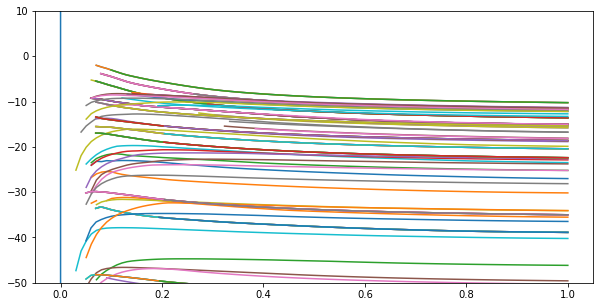

In [10]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

for i in range(100):
    ax.plot(alphas[i], scores[i])
    ax.set_ylim([-50, 10])

Text(0.5, 1.0, 'Partial Correlation Graphs using only negative edges')

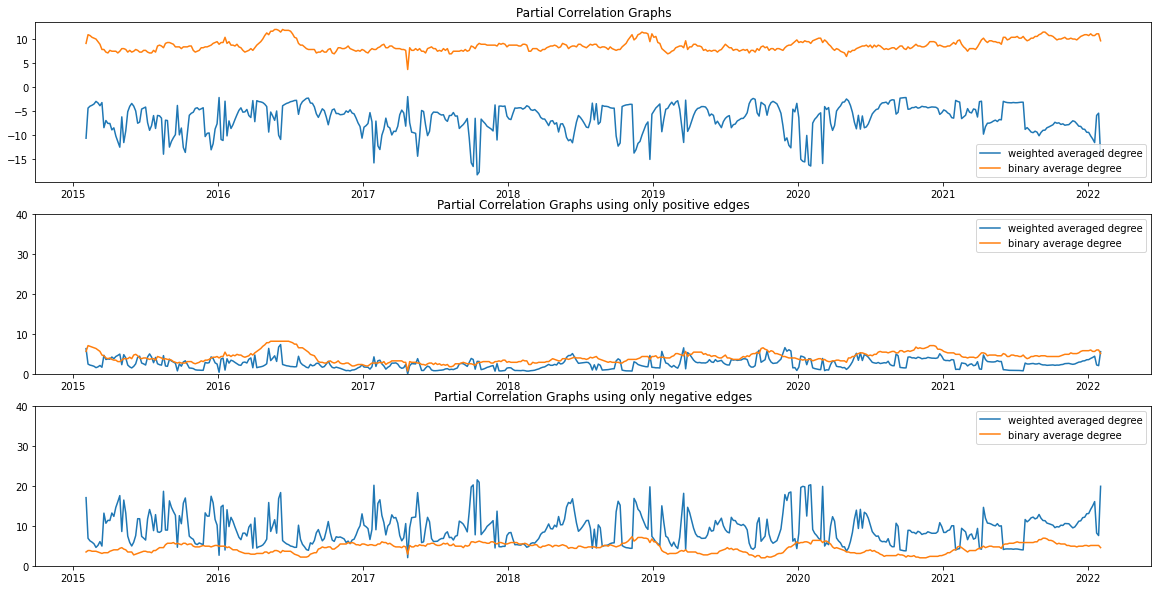

In [11]:
fig ,ax = plt.subplots(3,1, figsize = (20,10))

ax[0].plot(dates[:len(G_prec)], gf.avg_degree_list(G_prec,  weight = 'weight'), label = 'weighted averaged degree')
ax[0].plot(dates[:len(G_prec)],gf.avg_degree_list(G_prec), label = 'binary average degree')
ax[0].legend()
ax[0].set_title("Partial Correlation Graphs")

ax[1].plot(dates[:len(G_prec)], gf.avg_degree_list(G_pos,  weight = 'weight'), label = 'weighted averaged degree')
ax[1].plot(dates[:len(G_prec)], gf.avg_degree_list(G_pos), label = 'binary average degree')
ax[1].legend()
ax[1].set_ylim([0,40])
ax[1].set_title("Partial Correlation Graphs using only positive edges")

ax[2].plot(dates[:len(G_prec)], gf.avg_degree_list(G_neg,  weight = 'weight'), label = 'weighted averaged degree')
ax[2].plot(dates[:len(G_prec)],gf.avg_degree_list(G_neg), label = 'binary average degree')
ax[2].legend()
ax[2].set_ylim([0,40])
ax[2].set_title("Partial Correlation Graphs using only negative edges")

Looking at averge degrees no clear changes, but the average degrees may be sligtly higher after 2020, but some spikes, can be seen. Let's check if the degree of each sector

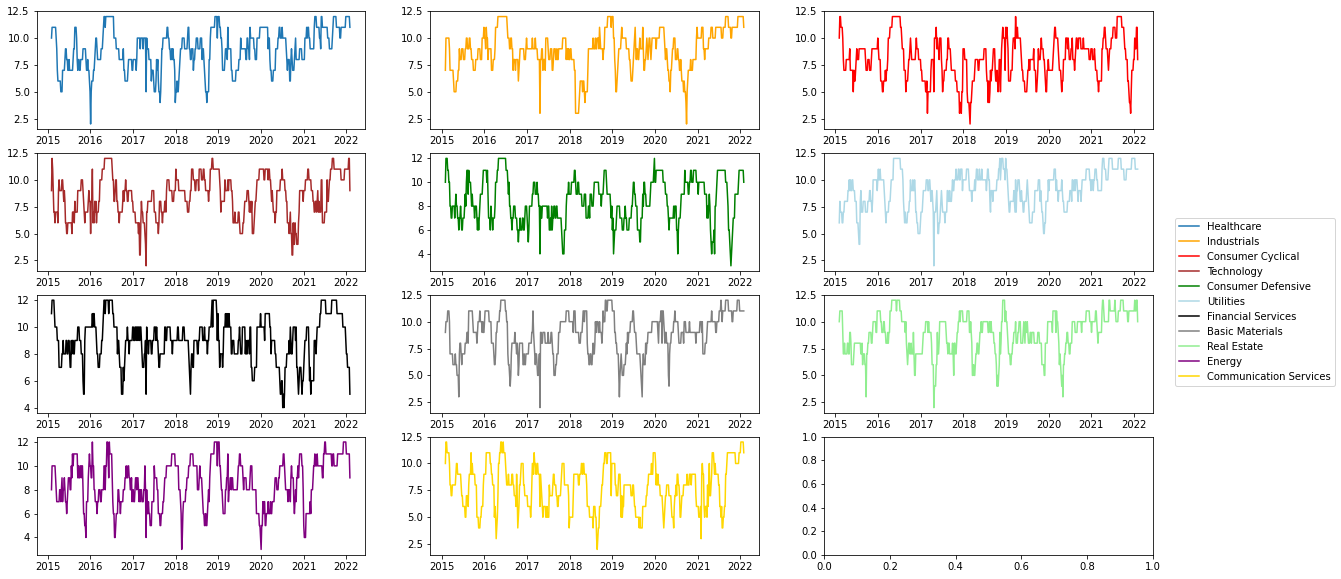

In [12]:
degree_df = pd.DataFrame()

for idx, G in enumerate(G_prec):

    tmp = pd.DataFrame({G.nodes('label')[k]:v for k, v in G.degree}, index= [idx])

    degree_df = pd.concat((degree_df, tmp))

fig ,ax = plt.subplots(4,3, figsize = (20,10))

ax[0,0].plot(dates, degree_df['Healthcare'], label = 'Healthcare')
ax[0,1].plot(dates, degree_df['Industrials'], label = 'Industrials', color = 'orange')
ax[0,2].plot(dates, degree_df['Consumer Cyclical'], label = 'Consumer Cyclical', color = 'red')
ax[1,0].plot(dates, degree_df['Technology'], label = 'Technology', color = 'brown')
ax[1,1].plot(dates, degree_df['Consumer Defensive'], label = 'Consumer Defensive', color = 'green')
ax[1,2].plot(dates, degree_df['Utilities'], label = 'Utilities', color = 'lightblue')
ax[2,0].plot(dates, degree_df['Financial Services'], label = 'Financial Services', color = 'black')
ax[2,1].plot(dates, degree_df['Basic Materials'], label = 'Basic Materials', color = 'grey')
ax[2,2].plot(dates, degree_df['Real Estate'], label = 'Real Estate', color = 'lightgreen')
ax[3,0].plot(dates, degree_df['Energy'], label = 'Energy', color = 'purple')
ax[3,1].plot(dates, degree_df['Communication Services'], label = 'Communication Services', color = 'gold')

fig.legend(bbox_to_anchor=(1.03, 0.6))

Test using WL kernel to take sector labels into account

In [15]:

type = 'signed'
shift_date = datetime.date(2019,11,1)
date_max_before_shift= np.max(np.where(dates < shift_date))

before_range = list(range((date_max_before_shift-60),date_max_before_shift))
after_range = list(range(date_max_before_shift,(date_max_before_shift+60)))

if type == 'pos':
    Gs_before = [G_pos[i] for i in before_range]
    Gs_after = [G_pos[i] for i in after_range]
elif type == 'neg':
    Gs_before = [G_neg[i] for i in before_range]
    Gs_after = [G_neg[i] for i in after_range]
elif type == 'signed':
    Gs_before = [G_signed[i] for i in before_range]
    Gs_after = [G_signed[i] for i in after_range]
elif type == 'all':
    Gs_before = [G_prec[i] for i in before_range]
    Gs_after = [G_prec[i] for i in after_range]
else:
    assert False

assert len(Gs_before) == len(Gs_after)

Gs = Gs_before + Gs_after

n = len(Gs_before)
m = len(Gs_after)

Text(0.5, 0, 'Date')

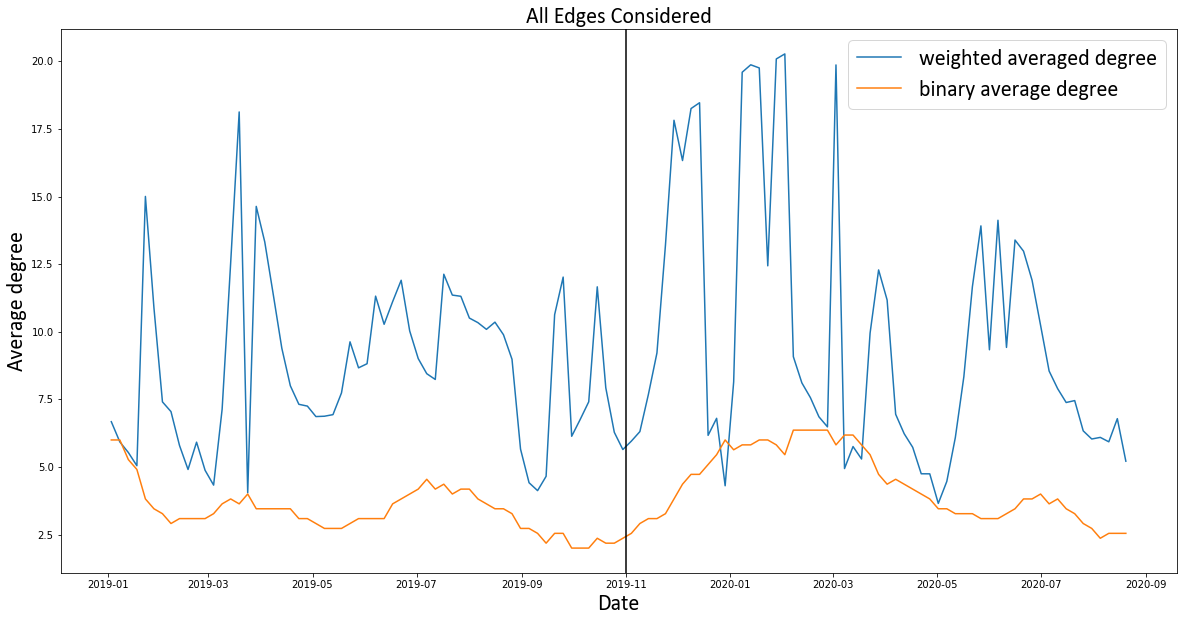

In [19]:
import matplotlib.font_manager as font_manager
fig ,ax = plt.subplots(1,1, figsize = (20,10))

axis_font = {'fontname':'Calibri', 'size':'22'}
font_prop = font_manager.FontProperties(family="Calibri", size=22)
ax.plot(dates[before_range + after_range], gf.avg_degree_list(Gs,  weight = 'weight'), label = 'weighted averaged degree')
ax.plot(dates[before_range + after_range],gf.avg_degree_list(Gs), label = 'binary average degree')
ax.axvline(x = shift_date, color = 'black')
ax.legend(prop = font_prop)
ax.set_title("All Edges Considered", **axis_font)
ax.set_ylabel("Average degree", **axis_font)
ax.set_xlabel("Date", **axis_font)


Plot average degree for the time period considered for each sector.

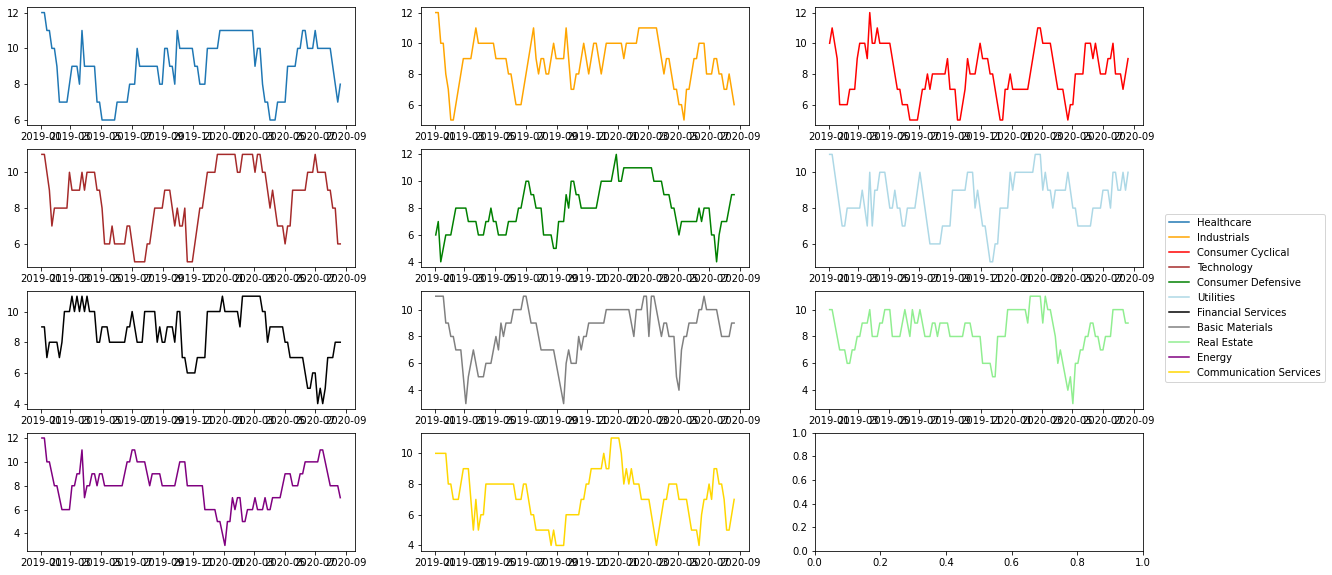

In [16]:
degree_df = pd.DataFrame()

for idx, G in enumerate(Gs):

    tmp = pd.DataFrame({G.nodes('label')[k]:v for k, v in G.degree}, index= [idx])

    degree_df = pd.concat((degree_df, tmp))

fig ,ax = plt.subplots(4,3, figsize = (20,10))

dates_period = dates[(date_max_before_shift-60):(date_max_before_shift+60)]
ax[0,0].plot(dates_period, degree_df['Healthcare'], label = 'Healthcare')
ax[0,1].plot(dates_period, degree_df['Industrials'], label = 'Industrials', color = 'orange')
ax[0,2].plot(dates_period, degree_df['Consumer Cyclical'], label = 'Consumer Cyclical', color = 'red')
ax[1,0].plot(dates_period, degree_df['Technology'], label = 'Technology', color = 'brown')
ax[1,1].plot(dates_period, degree_df['Consumer Defensive'], label = 'Consumer Defensive', color = 'green')
ax[1,2].plot(dates_period, degree_df['Utilities'], label = 'Utilities', color = 'lightblue')
ax[2,0].plot(dates_period, degree_df['Financial Services'], label = 'Financial Services', color = 'black')
ax[2,1].plot(dates_period, degree_df['Basic Materials'], label = 'Basic Materials', color = 'grey')
ax[2,2].plot(dates_period, degree_df['Real Estate'], label = 'Real Estate', color = 'lightgreen')
ax[3,0].plot(dates_period, degree_df['Energy'], label = 'Energy', color = 'purple')
ax[3,1].plot(dates_period, degree_df['Communication Services'], label = 'Communication Services', color = 'gold')

fig.legend(bbox_to_anchor=(1.03, 0.6))

In [18]:
warnings.resetwarnings()
# Grakel kernels
graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
# kernel = [{"name": "multiscale_laplacian"}]
# K = mg.KernelMatrix(graph_list, kernel, False)   
# kernel = [{"name": "weisfeiler_lehman", "n_iter": 4}, {"name": "vertex_histogram"}]
kernel = [{"name": "WL-OA", "n_iter": 2}]
# kernel = [{"name": "SP", "with_labels": 1}]
# kernel = [{"name": "lovasz_theta", "n_samples":20}]
#kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
# kernel = [{"name": "pyramid_match", "with_labels":False, "d":2, "L":4}] 
#kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.1, 'with_labels':False, 'p':3}]
# kernel = [{"name":'odd_sth', 'h':3}]
#kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "propagation", "t_max": 2, "w":0.01, "M":'TV'}]

init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
K = init_kernel.fit_transform(graph_list)

# label_list = np.unique(np.concatenate(label_list))
rw_kernel = rw.RandomWalk(Gs, c = 0.0001, normalize=0)
K = rw_kernel.fit_ARKU_edge(r=6,edge_labels = [1,-1], verbose = True)
# K = rw_kernel.fit_ARKL(r = 8, label_list = label_list, normalize_adj=True)
# K = rw_kernel.fit_ARKU_plus(r = 6, normalize_adj=False, verbose=True,edge_attr = 'weight')
# K = rw_kernel.fit_random_walk(mu_vec=[0.0, 1.0/(nnode_1*nnode_2)], k = 1, r = 3, normalize_adj=False ) # 1/((nnode_1-1)*(nnode_2-1)))


v,_ = np.linalg.eigh(K)
v[np.abs(v) < 10e-5] = 0
assert np.all(v) >= 0, "Not psd"


MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = m ), 
                    dict(n = n, m = m ),
                    dict(n = n, m = m ),  
                    dict(Q = 11, y1 = Gs[:n], y2 = Gs[m:] )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000)

# Run power
threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.05)
#print(f'threshold {threshold}')
ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], threshold, n)
#print(f'V {V}')
#print(f'ratio {ratio}')
print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

  0%|          | 0/7260.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:965: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A[idx] = scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G_tmp), dtype=np.float64)
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\networkx\linalg\graphmatrix.py:173: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  return nx.to_scipy_sparse_matrix(G, nodelist=nodelist, dtype=dtype, weight=weight)
100%|██████████| 7260/7260.0 [00:01<00:00, 6642.17it/s]


power 0.5638011099887477
p_value {'MMD_b': 0.0204, 'MMD_u': 0.0204, 'MMD_l': 0.0009, 'MONK_EST': 0.1999}
MMD_u 7.449593522820819e-07


In [13]:
kernel_hypothesis.p_values['MMD_b']

NameError: name 'kernel_hypothesis' is not defined

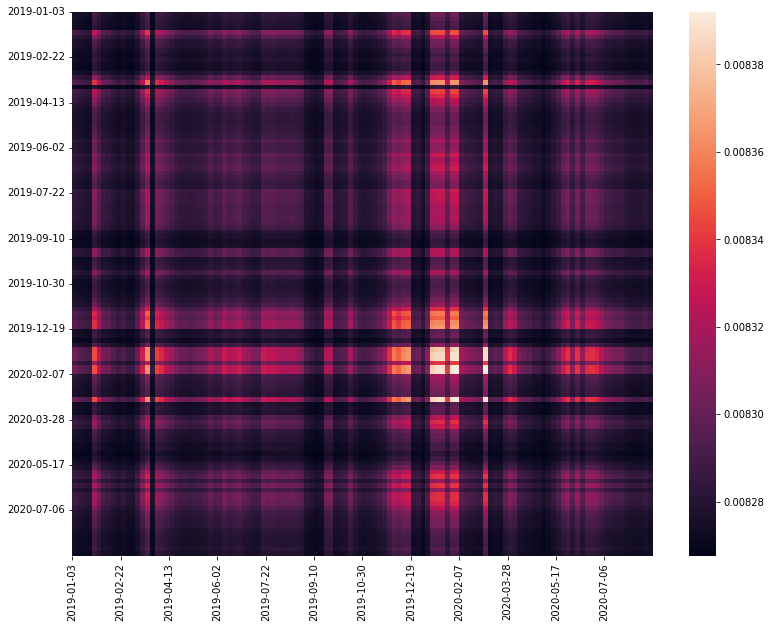

In [19]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(K, ax = ax)
ax.set_yticks( list(range(0, K.shape[0], 10)) ,labels=dates_period[::10])
ax.set_xticks( list(range(0, K.shape[0], 10)) ,labels=dates_period[::10])

In [67]:
Kxx = K[:n,:n]
Kyy = K[n:,n:]
Kxy = K[:n,n:]

np.mean(Kxx[range(0,n-1,2), range(1,n,2)])
np.mean(Kyy[range(0,n-1,2), range(1,n,2)])
np.mean(Kxy[range(0,n-1,2), range(1,n,2)])




0.010395505479445578

In [69]:
11%2

1

In [48]:
kernel_hypothesis.p_values['MMD_u']

0.0016

The WL kernel gives 0 p-value, but not obvious that this is the case when looking at the degree plots.

# Sector Return

In [5]:
return_sector = np.log(1 +price_sector.pct_change()).iloc[1:]


c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.438e-03
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.045e-03
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -4.213e-04
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.645e-04
  warnings.warn(


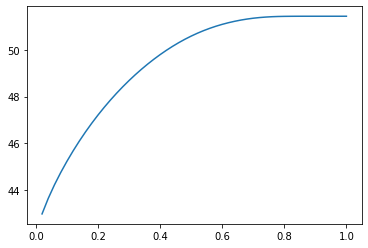

In [21]:
alphas = np.linspace(0.02,1, 50)
prec, costs = glasso_grid_search(np.array(return_sector.iloc[0:(125+0)].corr()), alphas)
plt.plot(alphas, costs)

Glasso minimum at regularization = 0

caculate precision on a rolling window, check if all only positive partial correlations (negative precision). If yes then we can use Palomar's LMGRF method with no problems

In [185]:
alphas = np.linspace(0.04,0.5,10)
is_all_pos_vec = []
nr_pos = []
nr_neg = []
dates = []
costs = []
N = 125
for i in tqdm.tqdm(range(0, return_sector.shape[0]-N,5)):

    dates.append(return_sector.index[N+i])

    names = {k:j for k, j in enumerate(return_sector.columns)}
    S = np.array(return_sector.iloc[i:(N+i)].corr())
    prec, cost = glasso_grid_search(S, alphas, max_iter=100)
    costs.append(cost)
    S = -np.linalg.inv(S)
    # S[np.abs(S) < 0.1] = 0
    is_all_pos_vec.append(np.all(S >= 0))
    nr_pos.append(np.sum(S[np.triu_indices(S.shape[0], k = 1)] > 0))
    nr_neg.append(np.sum(S[np.triu_indices(S.shape[0], k = 1)] < 0))



100%|██████████| 361/361 [00:38<00:00,  9.48it/s]


<AxesSubplot:>

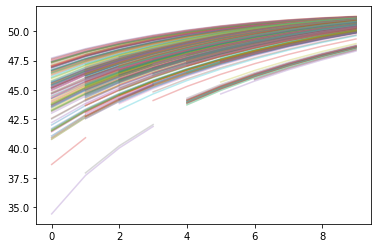

In [190]:
pd.DataFrame(np.array(costs).T).plot(legend = None, alpha = 0.3)

Loss is always increasing

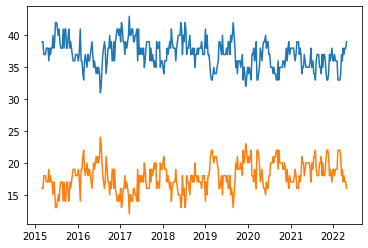

In [191]:
#plt.plot(times,is_all_pos_vec)
plt.plot(times,nr_pos)
plt.plot(times,nr_neg)

We have negative correlations. Generate graphs different graphs using the empirical precision matrix. From precision, only positive relations, only negative relations and signed relations

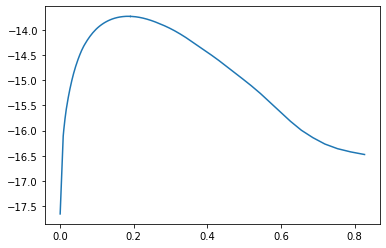

In [35]:
scaler = StandardScaler()
X = scaler.fit_transform(return_sector.iloc[140:(N+140)])
out_esg_glasso = GraphicalLassoCV(cv = 3, alphas=100).fit(X)
plt.plot(out_esg_glasso.cv_results_['alphas'], out_esg_glasso.cv_results_['mean_test_score'])

In [ ]:
alphas = []
scores = []

warnings.filterwarnings("ignore")
for i in tqdm.tqdm(range(0, sector_gp.shape[0]-N,5)):

    calculation_bad = True
    start_alpha = 0
    alphas_cv = list(np.linspace(start_alpha,1,100))
    
    while calculation_bad:

        names = {k:j for k, j in enumerate(sector_gp.columns)}
        #S = np.array(sector_gp.iloc[i:(N+i)].corr())
        scaler = StandardScaler()
        X = scaler.fit_transform(sector_gp.iloc[i:(N+i)])

        #prec, costs = glasso_grid_search(S, alphas, max_iter=100)

        try:
            out_esg_glasso = GraphicalLassoCV(cv = 3, alphas=alphas_cv).fit(X)
        except:
            # print(f'{i} {sector_gp.index[N+i]} failed ')
            calculation_bad = True
            start_alpha += 0.01
            alphas_cv = list(np.linspace(start_alpha,1,100))
            print(f'{i} {sector_gp.index[N+i]} failed {start_alpha} ')
            continue
        calculation_bad = False
        alphas.append(out_esg_glasso.cv_results_['alphas'])
        scores.append(out_esg_glasso.cv_results_['mean_score'])

        prec = -out_esg_glasso.precision_

        if np.max(np.abs(prec)) > 10:
            calculation_bad = True
            start_alpha += 0.01
            alphas_cv = list(np.linspace(start_alpha,1,100))
            print(f'{i} {sector_gp.index[N+i]} failed, too high precision {start_alpha} ')
            continue

In [10]:
#alphas = np.linspace(0.04,0.5,10)
is_all_pos_vec = []
nr_pos = []
nr_neg = []
dates2 = []
N = 200

G2_prec = [] # all correlation graph
G2_pos = [] # only positve correlation weighted
G2_neg = [] # only negative correlation weighted
G2_signed = [] # Sign

alphas2 = []
scores2 = []

warnings.filterwarnings("ignore")
for i in tqdm.tqdm(range(0, return_sector.shape[0]-N,5)):

    calculation_bad = True
    start_alpha = 0
    alphas_cv = list(np.linspace(start_alpha,1,100))
    
    while calculation_bad:

        names = {k:j for k, j in enumerate(sector_gp.columns)}
        #S = np.array(sector_gp.iloc[i:(N+i)].corr())
        scaler = StandardScaler()
        X = scaler.fit_transform(return_sector.iloc[i:(N+i)])

        #prec, costs = glasso_grid_search(S, alphas, max_iter=100)

        try:
            out_esg_glasso = GraphicalLassoCV(cv = 3, alphas=alphas_cv).fit(X)
        except:
            # print(f'{i} {sector_gp.index[N+i]} failed ')
            calculation_bad = True
            start_alpha += 0.01
            alphas_cv = list(np.linspace(start_alpha,1,100))
            print(f'{i} {return_sector.index[N+i]} failed {start_alpha} ')
            continue
        calculation_bad = False
        alphas2.append(out_esg_glasso.cv_results_['alphas'])
        scores2.append(out_esg_glasso.cv_results_['mean_score'])

        prec = -out_esg_glasso.precision_

        if np.max(np.abs(prec)) > 10:
            calculation_bad = True
            start_alpha += 0.01
            alphas_cv = list(np.linspace(start_alpha,1,100))
            print(f'{i} {return_sector.index[N+i]} failed, too high precision {start_alpha} ')
            continue


    prec = -out_esg_glasso.precision_
    # All edges
    G = nx.from_numpy_array(prec)
    nx.set_node_attributes(G, names, "label")
    G2_prec.append(G)
    # positive edges
    prec_pos = prec.copy()
    prec_pos[prec_pos <0] = 0
    G = nx.from_numpy_array(prec_pos)
    nx.set_node_attributes(G, names, "label")
    G2_pos.append(G)
    # negative edges
    prec_neg = prec.copy()
    prec_neg[prec_neg >0] = 0
    G = nx.from_numpy_array(np.abs(prec_neg))
    nx.set_node_attributes(G, names, "label")
    G2_neg.append(G)
    # signed
    G = nx.from_numpy_array(prec)
    nx.set_edge_attributes(G, {(n1, n2): np.sign(val) for n1, n2, val in G.edges.data('weight')}, "sign")
    G2_signed.append(G)

    dates2.append(return_sector.index[N+i])

dates2 = np.array(dates2)

warnings.filterwarnings("default")

 69%|██████▉   | 239/346 [02:20<01:07,  1.58it/s]

1195 2020-03-19 failed, too high precision 0.01 
1195 2020-03-19 failed, too high precision 0.02 
1195 2020-03-19 failed, too high precision 0.03 
1195 2020-03-19 failed, too high precision 0.04 
1195 2020-03-19 failed, too high precision 0.05 


 69%|██████▉   | 240/346 [02:25<03:23,  1.92s/it]

1200 2020-03-26 failed, too high precision 0.01 


 70%|██████▉   | 241/346 [02:27<03:02,  1.74s/it]

1205 2020-04-02 failed, too high precision 0.01 
1205 2020-04-02 failed, too high precision 0.02 
1205 2020-04-02 failed, too high precision 0.03 
1205 2020-04-02 failed, too high precision 0.04 
1205 2020-04-02 failed, too high precision 0.05 


 70%|██████▉   | 242/346 [02:31<04:35,  2.65s/it]

1210 2020-04-09 failed, too high precision 0.01 
1210 2020-04-09 failed, too high precision 0.02 
1210 2020-04-09 failed, too high precision 0.03 
1210 2020-04-09 failed, too high precision 0.04 
1210 2020-04-09 failed, too high precision 0.05 


 71%|███████   | 244/346 [02:37<04:22,  2.58s/it]

1220 2020-04-24 failed, too high precision 0.01 
1220 2020-04-24 failed, too high precision 0.02 
1220 2020-04-24 failed, too high precision 0.03 
1220 2020-04-24 failed, too high precision 0.04 
1220 2020-04-24 failed, too high precision 0.05 


 71%|███████   | 245/346 [02:42<05:24,  3.21s/it]

1225 2020-05-01 failed, too high precision 0.01 
1225 2020-05-01 failed, too high precision 0.02 
1225 2020-05-01 failed, too high precision 0.03 
1225 2020-05-01 failed, too high precision 0.04 
1225 2020-05-01 failed, too high precision 0.05 


 71%|███████   | 246/346 [02:47<06:07,  3.67s/it]

1230 2020-05-08 failed, too high precision 0.01 
1230 2020-05-08 failed, too high precision 0.02 
1230 2020-05-08 failed, too high precision 0.03 
1230 2020-05-08 failed, too high precision 0.04 
1230 2020-05-08 failed, too high precision 0.05 


 71%|███████▏  | 247/346 [02:51<06:32,  3.96s/it]

1235 2020-05-15 failed, too high precision 0.01 


 72%|███████▏  | 248/346 [02:53<05:14,  3.21s/it]

1240 2020-05-22 failed, too high precision 0.01 


 72%|███████▏  | 249/346 [02:54<04:18,  2.67s/it]

1245 2020-06-01 failed, too high precision 0.01 


 72%|███████▏  | 250/346 [02:56<03:39,  2.29s/it]

1250 2020-06-08 failed, too high precision 0.01 


 74%|███████▎  | 255/346 [03:00<01:38,  1.08s/it]

1275 2020-07-14 failed, too high precision 0.01 
1275 2020-07-14 failed, too high precision 0.02 
1275 2020-07-14 failed, too high precision 0.03 
1275 2020-07-14 failed, too high precision 0.04 
1275 2020-07-14 failed, too high precision 0.05 


 74%|███████▍  | 256/346 [03:05<03:10,  2.12s/it]

1280 2020-07-21 failed, too high precision 0.01 
1280 2020-07-21 failed, too high precision 0.02 
1280 2020-07-21 failed, too high precision 0.03 
1280 2020-07-21 failed, too high precision 0.04 
1280 2020-07-21 failed, too high precision 0.05 


 75%|███████▍  | 259/346 [03:11<02:37,  1.81s/it]

1295 2020-08-11 failed, too high precision 0.01 
1295 2020-08-11 failed, too high precision 0.02 


 75%|███████▌  | 261/346 [03:14<02:17,  1.62s/it]

1305 2020-08-25 failed, too high precision 0.01 


 76%|███████▌  | 262/346 [03:16<02:13,  1.59s/it]

1310 2020-09-01 failed, too high precision 0.01 


 77%|███████▋  | 267/346 [03:20<01:17,  1.02it/s]

1335 2020-10-07 failed, too high precision 0.01 
1335 2020-10-07 failed, too high precision 0.02 


 77%|███████▋  | 268/346 [03:23<01:49,  1.41s/it]

1340 2020-10-14 failed, too high precision 0.01 
1340 2020-10-14 failed, too high precision 0.02 
1340 2020-10-14 failed, too high precision 0.03 
1340 2020-10-14 failed, too high precision 0.04 


 80%|████████  | 278/346 [03:34<00:57,  1.18it/s]

1390 2020-12-24 failed, too high precision 0.01 


100%|██████████| 346/346 [04:13<00:00,  1.37it/s]


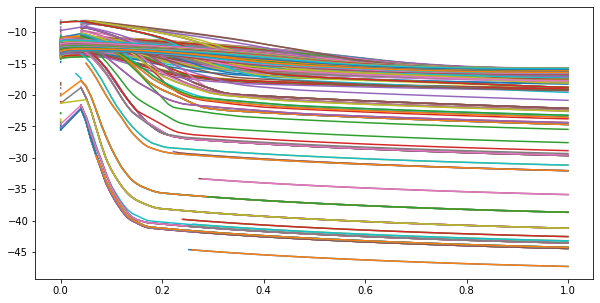

In [11]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

for i in range(len(alphas2)):
    ax.plot(alphas2[i], scores2[i])

Text(0.5, 0, 'Date')

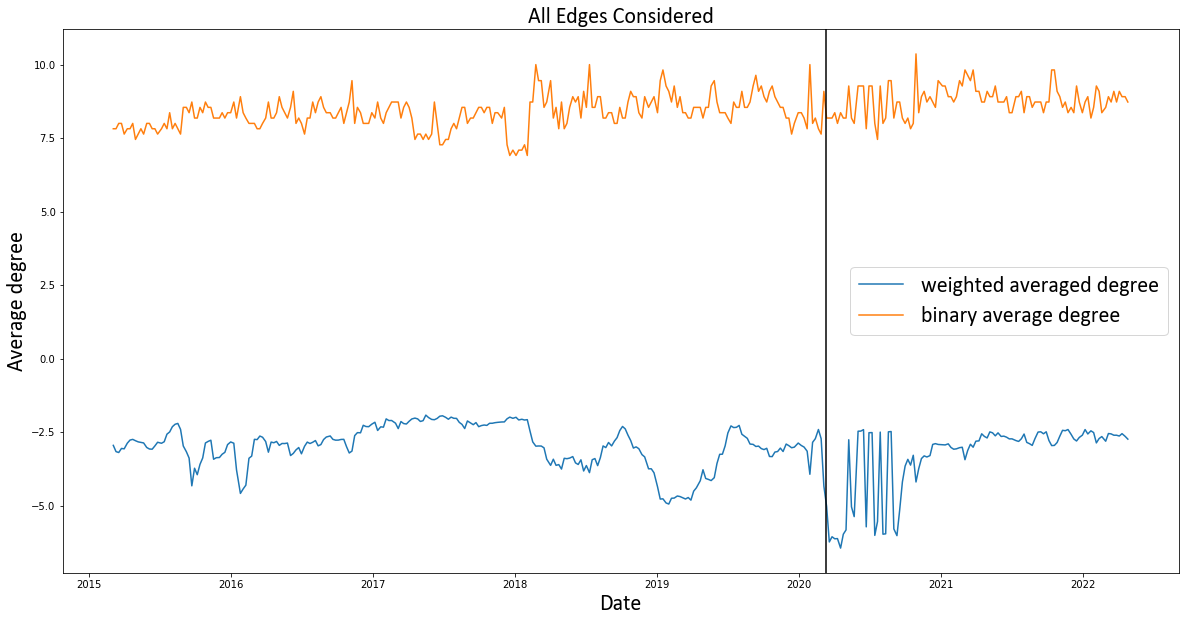

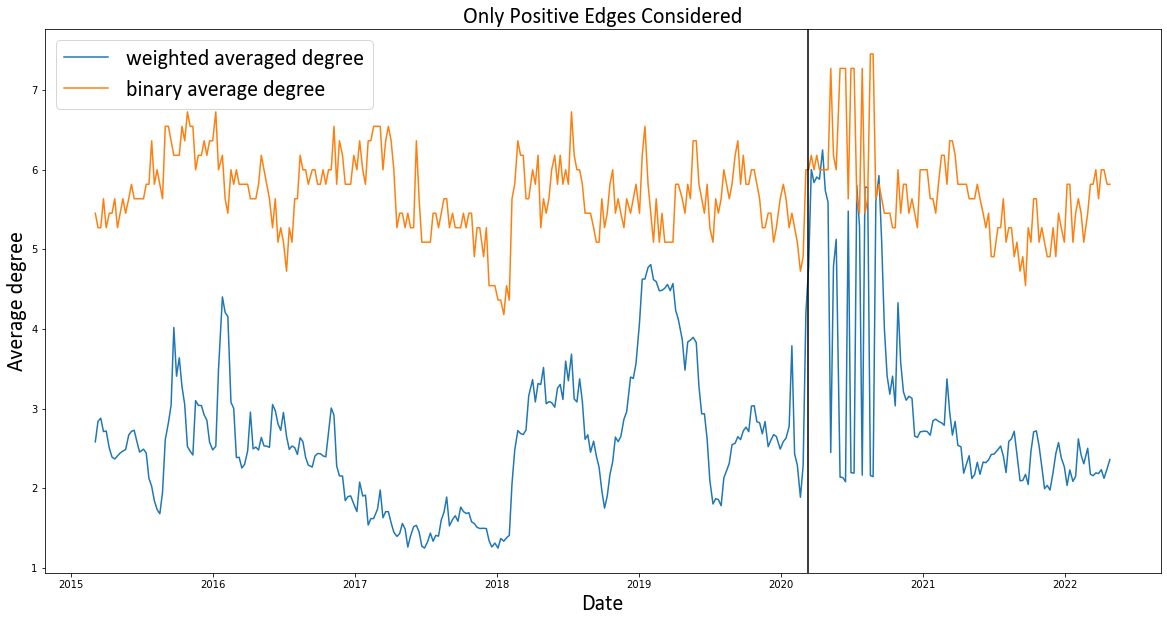

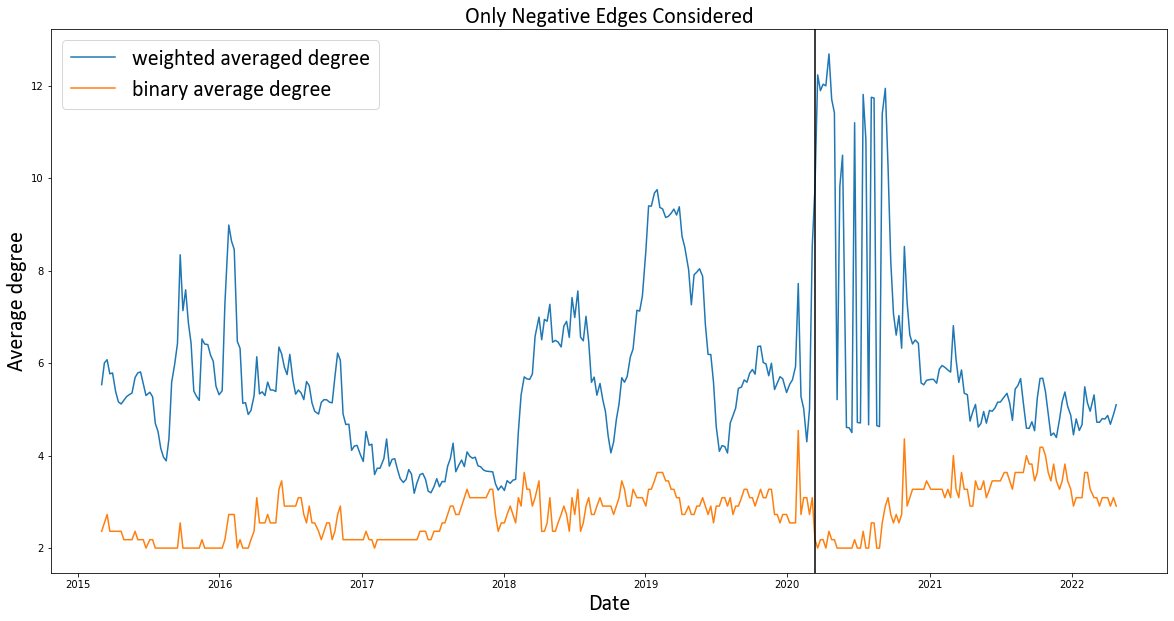

In [36]:
import matplotlib.font_manager as font_manager
covid_date = datetime.date(2020,3,11)
fig ,ax = plt.subplots(1,1, figsize = (20,10))

axis_font = {'fontname':'Calibri', 'size':'22'}
font_prop = font_manager.FontProperties(family="Calibri", size=22)
ax.plot(dates2, gf.avg_degree_list(G2_prec,  weight = 'weight'), label = 'weighted averaged degree')
ax.plot(dates2,gf.avg_degree_list(G2_prec), label = 'binary average degree')
ax.axvline(x = covid_date, color = 'black')
ax.legend(prop = font_prop)
ax.set_title("All Edges Considered", **axis_font)
ax.set_ylabel("Average degree", **axis_font)
ax.set_xlabel("Date", **axis_font)


fig ,ax = plt.subplots(1,1, figsize = (20,10))
axis_font = {'fontname':'Calibri', 'size':'22'}
font_prop = font_manager.FontProperties(family="Calibri", size=22)
ax.plot(dates2, gf.avg_degree_list(G2_pos,  weight = 'weight'), label = 'weighted averaged degree')
ax.plot(dates2,gf.avg_degree_list(G2_pos), label = 'binary average degree')
ax.axvline(x = covid_date, color = 'black')
ax.legend(prop = font_prop)
ax.set_title("Only Positive Edges Considered", **axis_font)
ax.set_ylabel("Average degree", **axis_font)
ax.set_xlabel("Date", **axis_font)


fig ,ax = plt.subplots(1,1, figsize = (20,10))
axis_font = {'fontname':'Calibri', 'size':'22'}
font_prop = font_manager.FontProperties(family="Calibri", size=22)
ax.plot(dates2, gf.avg_degree_list(G2_neg,  weight = 'weight'), label = 'weighted averaged degree')
ax.plot(dates2,gf.avg_degree_list(G2_neg), label = 'binary average degree')
ax.axvline(x = covid_date, color = 'black')
ax.legend(prop = font_prop)
ax.set_title("Only Negative Edges Considered", **axis_font)
ax.set_ylabel("Average degree", **axis_font)
ax.set_xlabel("Date", **axis_font)



Create two samples and test

In [12]:
type = 'pos'
covid_date = datetime.date(2020,3,11)
date_max_before_covid = np.max(np.where(dates2 < covid_date))

before_range = list(range((date_max_before_covid-60),date_max_before_covid))
after_range = list(range(date_max_before_covid,(date_max_before_covid+60)))

if type == 'pos':
    Gs_before = [G2_pos[i] for i in (before_range)]
    Gs_after = [G2_pos[i] for i in (after_range)]
elif type == 'neg':
    Gs_before = [G2_neg[i] for i in (before_range)]
    Gs_after = [G2_neg[i] for i in (after_range)]
elif type == 'signed':
    Gs_before = [G2_signed[i] for i in (before_range)]
    Gs_after = [G2_signed[i] for i in (after_range)]
else:
    assert False

dates_before = dates2[before_range]
dates_after = dates2[after_range]

# if type == 'pos':
#     Gs_before = [G2_pos[i] for i in range(0,100)]
#     Gs_after = [G2_pos[i] for i in range(100,200)]
# elif type == 'neg':
#     Gs_before = [G2_neg[i] for i in range((date_max_before_covid-50),date_max_before_covid)]
#     Gs_after = [G2_neg[i] for i in range(date_max_before_covid,(date_max_before_covid+50))]
# elif type == 'signed':
#     Gs_before = [G2_signed[i] for i in range((date_max_before_covid-50),date_max_before_covid)]
#     Gs_after = [G2_signed[i] for i in range(date_max_before_covid,(date_max_before_covid+50))]
# else:
#     assert False

# detes_before = dates[0:100]
# detes_after = dates[100:200]

assert len(Gs_before) == len(Gs_after)

Gs = Gs_before + Gs_after

n = len(Gs_before)
m = len(Gs_after)

Text(0.5, 0, 'Date')

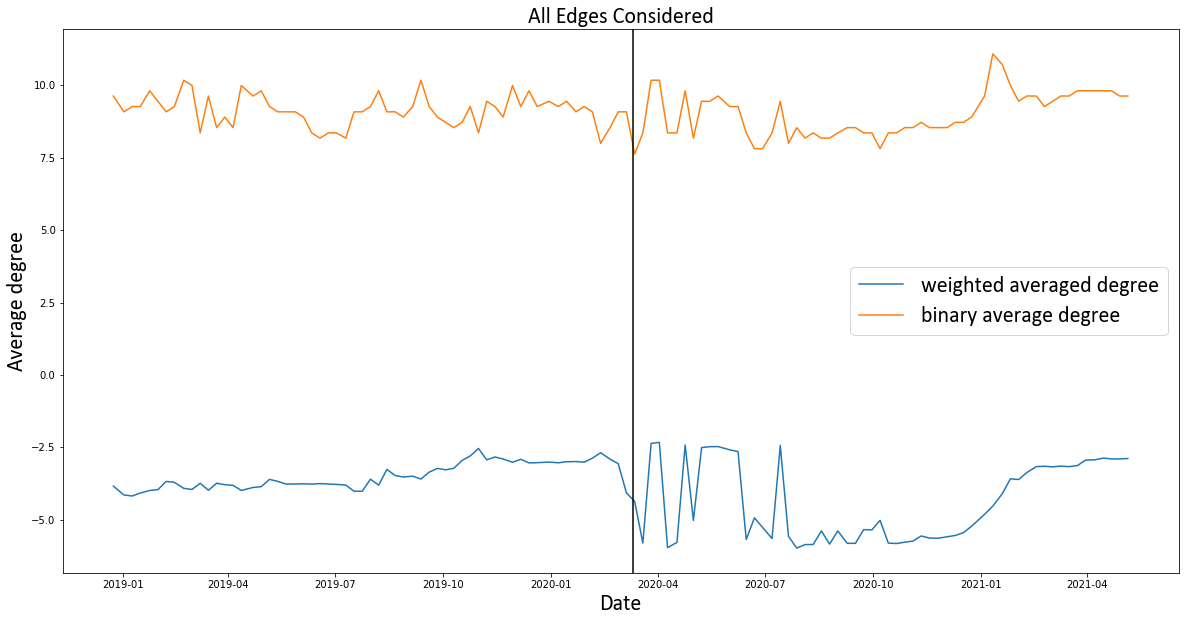

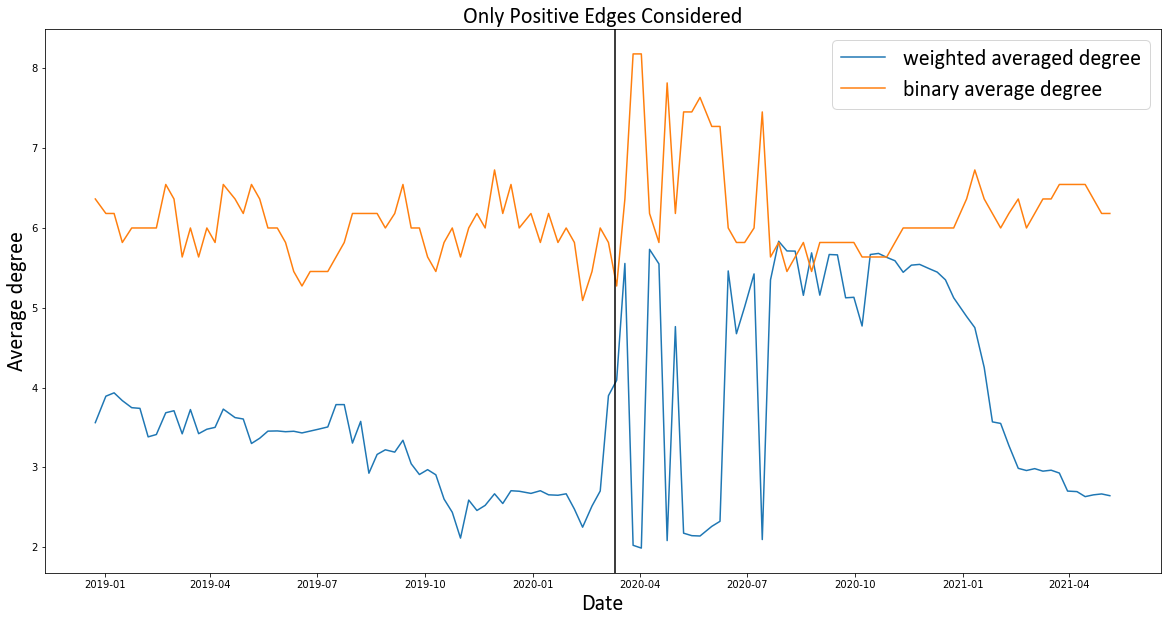

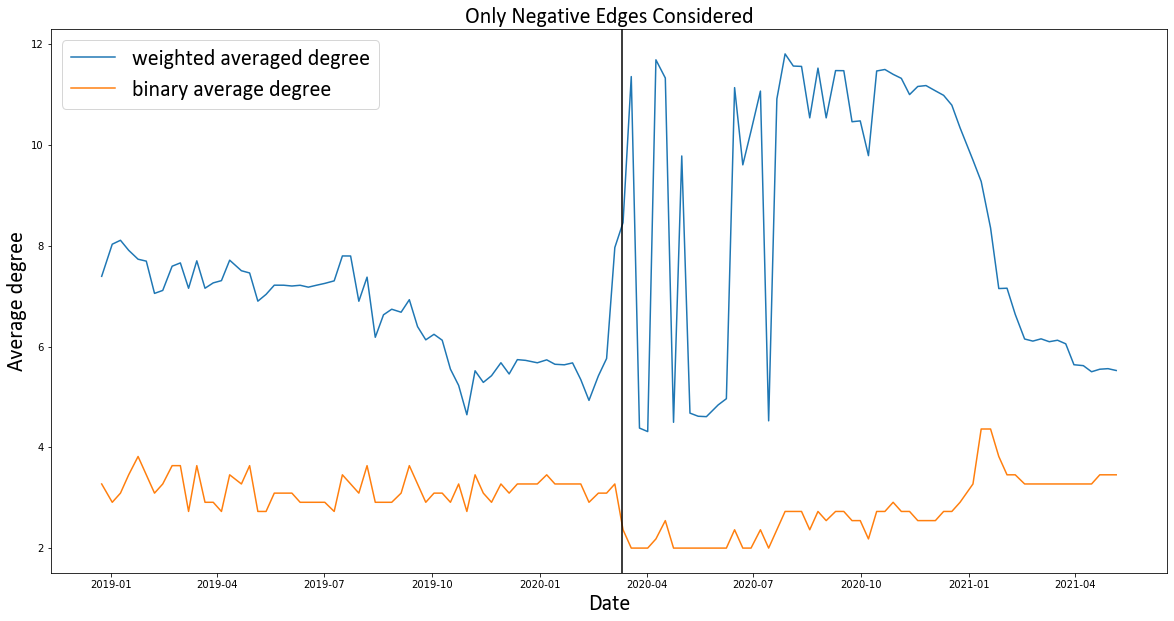

In [13]:
import matplotlib.font_manager as font_manager
covid_date = datetime.date(2020,3,11)
fig ,ax = plt.subplots(1,1, figsize = (20,10))

axis_font = {'fontname':'Calibri', 'size':'22'}
font_prop = font_manager.FontProperties(family="Calibri", size=22)
ax.plot(dates2[before_range + after_range], gf.avg_degree_list([G2_prec[i] for i in before_range + after_range],  weight = 'weight'), label = 'weighted averaged degree')
ax.plot(dates2[before_range + after_range],gf.avg_degree_list([G2_prec[i] for i in before_range + after_range]), label = 'binary average degree')
ax.axvline(x = covid_date, color = 'black')
ax.legend(prop = font_prop)
ax.set_title("All Edges Considered", **axis_font)
ax.set_ylabel("Average degree", **axis_font)
ax.set_xlabel("Date", **axis_font)


fig ,ax = plt.subplots(1,1, figsize = (20,10))
axis_font = {'fontname':'Calibri', 'size':'22'}
font_prop = font_manager.FontProperties(family="Calibri", size=22)
ax.plot(dates2[before_range + after_range], gf.avg_degree_list([G2_pos[i] for i in before_range + after_range],  weight = 'weight'), label = 'weighted averaged degree')
ax.plot(dates2[before_range + after_range],gf.avg_degree_list([G2_pos[i] for i in before_range + after_range]), label = 'binary average degree')
ax.axvline(x = covid_date, color = 'black')
ax.legend(prop = font_prop)
ax.set_title("Only Positive Edges Considered", **axis_font)
ax.set_ylabel("Average degree", **axis_font)
ax.set_xlabel("Date", **axis_font)




fig ,ax = plt.subplots(1,1, figsize = (20,10))
axis_font = {'fontname':'Calibri', 'size':'22'}
font_prop = font_manager.FontProperties(family="Calibri", size=22)
ax.plot(dates2[before_range + after_range], gf.avg_degree_list([G2_neg[i] for i in before_range + after_range],  weight = 'weight'), label = 'weighted averaged degree')
ax.plot(dates2[before_range + after_range], gf.avg_degree_list([G2_neg[i] for i in before_range + after_range]), label = 'binary average degree')
ax.axvline(x = covid_date, color = 'black')
ax.legend(prop = font_prop)
ax.set_title("Only Negative Edges Considered", **axis_font)
ax.set_ylabel("Average degree", **axis_font)
ax.set_xlabel("Date", **axis_font)

MMD test

In [9]:

# label_list = np.unique(np.concatenate(label_list))
rw_kernel = rw.RandomWalk(Gs, c = 0.0001, normalize=0)
# K = rw_kernel.fit_ARKL(r = 8, label_list = label_list, normalize_adj=True)
K = rw_kernel.fit_ARKU_plus(r = 6, normalize_adj=False, verbose=True,edge_attr = None)
#K = rw_kernel.fit_random_walk(mu_vec=[0.0, 1.0/(nnode_1*nnode_2)], k = 1, r = 3, normalize_adj=False ) # 1/((nnode_1-1)*(nnode_2-1)))

graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
# kernel = [{"name": "multiscale_laplacian"}]
# K = mg.KernelMatrix(graph_list, kernel, False)   
kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "vertex_histogram"}]
# kernel = [{"name": "WL-OA", "n_iter": 4}]
# kernel = [{"name": "SP", "with_labels": 1}]
# kernel = [{"name": "lovasz_theta", "n_samples":20}]
#kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
# kernel = [{"name": "pyramid_match", "with_labels":False, "d":2, "L":4}] 
#kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.1, 'with_labels':False, 'p':3}]
# kernel = [{"name":'odd_sth', 'h':3}]
#kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "propagation", "t_max": 2, "w":0.01, "M":'TV'}]

#init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
#K = init_kernel.fit_transform(graph_list)

v,_ = np.linalg.eigh(K)
v[np.abs(v) < 10e-5] = 0
assert np.all(v) >= 0, "Not psd"

MMD_functions = [mg.MMD_b, mg.MMD_u]#, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = m ), 
                    dict(n = n, m = m )]#, 
                    #dict(Q = 11, y1 = Gs[:n], y2 = Gs[n:] )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000)






# Run power
threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.05)
#print(f'threshold {threshold}')
ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], threshold, n)
#print(f'V {V}')
#print(f'ratio {ratio}')
print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
#print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

  0%|          | 0/7260.0 [00:00<?, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\networkx\linalg\graphmatrix.py:173: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  return nx.to_scipy_sparse_matrix(G, nodelist=nodelist, dtype=dtype, weight=weight)
 41%|████      | 2989/7260.0 [00:01<00:01, 2655.63it/s]

KeyboardInterrupt: 

<AxesSubplot:>

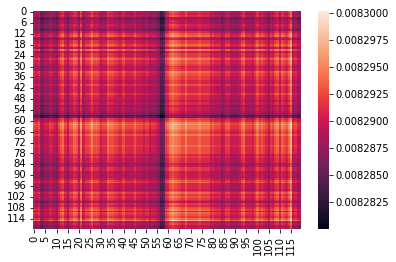

In [57]:
sns.heatmap(K)

The test was (obisoulsy) always going to be rejected if we look at the average degree and using the RW kernel. Let's test how many samples we need in order

In [61]:
p_vals = []
m_vec = np.array(range(2,len(Gs_after)))
for m in tqdm.tqdm(range(2,len(m_vec))):

    Gs = Gs_before + [Gs_after[i] for i in range(m)]

    # label_list = np.unique(np.concatenate(label_list))
    rw_kernel = rw.RandomWalk(Gs, c = 0.0001, normalize=0)
    # K = rw_kernel.fit_ARKL(r = 8, label_list = label_list, normalize_adj=True)
    K = rw_kernel.fit_ARKU_plus(r = 6, normalize_adj=False, verbose=False,edge_attr = 'weight')
    # K = rw_kernel.fit_random_walk(mu_vec=[0.0, 1.0/(nnode_1*nnode_2)], k = 1, r = 3, normalize_adj=False ) # 1/((nnode_1-1)*(nnode_2-1)))

    v,_ = np.linalg.eigh(K)
    assert not np.any(v < -1e-10), "K not psd"


    MMD_functions = [ mg.MMD_u]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    function_arguments = [dict(n = n, m = m )]#, 
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000)

    # Run power
    # threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.05)
    #print(f'threshold {threshold}')
    # ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], threshold, n)
    #print(f'V {V}')
    #print(f'ratio {ratio}')
    #print(f'power {power}')
    #print(f'p_value {kernel_hypothesis.p_values}')
    #print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")
    p_vals.append(kernel_hypothesis.p_values['MMD_u'])

100%|██████████| 56/56 [01:41<00:00,  1.81s/it]


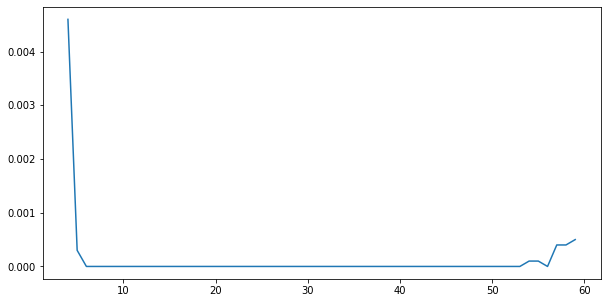

In [64]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(m_vec[2:], p_vals)


# Bipartite

In [45]:
esg_and_price = pd.merge(sector_gp, price_sector, left_index=True, right_index = True)
scaler = StandardScaler()
i = 100
X = scaler.fit_transform(esg_and_price.iloc[i:(90+i)])

<AxesSubplot:>

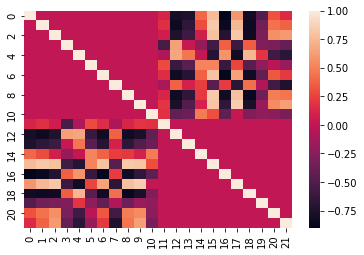

In [46]:
S_12 = np.corrcoef(X.T)[:11, 11:]

S_block = np.block([[np.identity(S_12.shape[0]), S_12], [S_12.T, np.identity(S_12.shape[0])]])
sns.heatmap(S_block)

Use R package to calculate find bipartite graph

<AxesSubplot:>

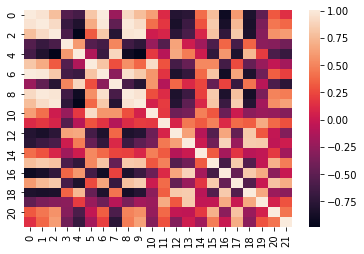

In [47]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
spectralGraphTopology = importr('spectralGraphTopology')
igraph = importr('igraph')
S = np.cov(X.T)
sns.heatmap(S)

False

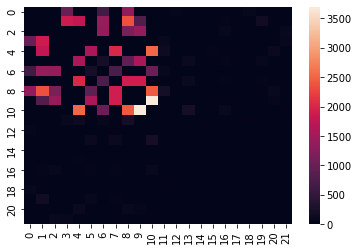

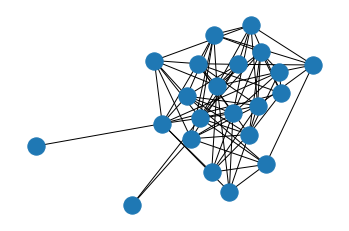

In [49]:
N = 120
i = 50
esg_and_price = pd.merge(sector_gp, price_sector, left_index=True, right_index = True)
scaler = StandardScaler()
X = scaler.fit_transform(esg_and_price.iloc[i:(120+i)])
S = np.corrcoef(X.T)

#scaler = StandardScaler()
#X = scaler.fit_transform(price_sector.iloc[i:(N+i)])
#S = np.corrcoef(X.T)

#scaler = StandardScaler()
#X = scaler.fit_transform(sector_gp.iloc[i:(N+i)])
#S = np.cov(X.T)


out = spectralGraphTopology.learn_bipartite_graph(S = S, is_data_matrix = False, alpha = 10)#, w0 = 'qp', alpha = 10)
#out = spectralGraphTopology.learn_bipartite_graph(S = X.T, is_data_matrix = True)
out = dict(zip(out.names, list(out)))
A = out['adjacency']
# A[np.abs(A) <= 0.1] = 0 
sns.heatmap(A)

fig, ax = plt.subplots(1,1)
G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, weight = None)
nx.draw(G, pos, ax = ax)
nx.is_bipartite(G)

In [82]:
L = out['laplacian']
np.sum(L, axis = 1)

array([ 0.00000000e+00,  0.00000000e+00, -9.09494702e-13,  1.09139364e-11,
       -9.09494702e-13,  1.45519152e-11, -1.45519152e-11, -5.18411980e-11,
       -3.86535248e-11,  1.59161573e-11,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [80]:
v,_ =np.linalg.eigh(A)
v

array([-4.35292260e+05, -1.51355812e+04, -7.68692011e+03, -1.14840107e+03,
       -7.29852549e+02, -6.92858027e-11, -6.73519436e-11, -6.04599826e-11,
       -5.27510102e-11, -3.73434643e-11, -3.35203526e-11, -1.40735392e-11,
        8.75353178e-12,  2.46870559e-11,  3.84758260e-11,  4.74134892e-11,
        5.36602873e-11,  7.29852549e+02,  1.14840107e+03,  7.68692011e+03,
        1.51355812e+04,  4.35292260e+05])

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\networkx\convert_matrix.py:686: DeprecationWarning: from_numpy_matrix is deprecated and will be removed in NetworkX 3.0.
Use from_numpy_array instead, e.g. from_numpy_array(A, **kwargs)
  warnings.warn(


False

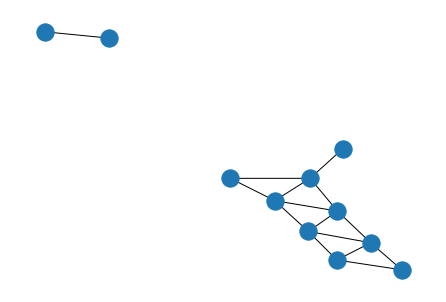

In [27]:
G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, weight = None)
nx.draw(G, pos)
nx.is_bipartite(G)

True

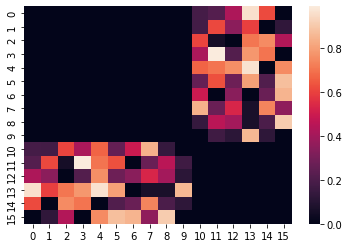

In [20]:
robjects.r('''
             library(spectralGraphTopology)
            library(igraph)
            library(viridis)
            library(corrplot)
            set.seed(42)

            f = function(){
            # define number of nodes on each set
            n1 <- 10
            n2 <- 6
            n <- n1 + n2
            # define the probability of connection among nodes of different sets
            pc <- .9

            # sample a bipartite graph
            bipartite <- sample_bipartite(n1, n2, type="Gnp", p = pc, directed=FALSE)
            # randomly assign edge weights to connected nodes
            E(bipartite)$weight <- runif(gsize(bipartite), min = 0, max = 1)
            # get true Laplacian and Adjacency
            Ltrue <- as.matrix(laplacian_matrix(bipartite))
            Atrue <- diag(diag(Ltrue)) - Ltrue
            # get samples
            Y <- MASS::mvrnorm(100 * n, rep(0, n), Sigma = MASS::ginv(Ltrue))
            # compute sample covariance matrix
            S <- cov(Y)
            return(S)
            }

            S = f()
         ''')


out = spectralGraphTopology.learn_bipartite_graph(S = robjects.globalenv["S"])
out = dict(zip(out.names, list(out)))

A = out['adjacency']
A[np.abs(A) <= 0.01] = 0
sns.heatmap(A)



G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, weight = None)
#nx.draw(G, pos)
nx.is_bipartite(G)

# Individual Stock return per sector

In [23]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
spectralGraphTopology = importr('spectralGraphTopology')
igraph = importr('igraph')
fingraph = importr('fingraph')
fitHeavyTail = importr('fitHeavyTail')


In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(price_pivot.loc[:, np.isin(price_pivot.columns,sector_classification['Energy'])].iloc[i:(i+N)])
out_fit_mvt = fitHeavyTail.fit_mvt(X,nu="MLE-diag-resample")
out_fit_mvt = dict(zip(out_fit_mvt.names, list(out_fit_mvt)))

LGMRF by palomar and et.

In [80]:
N = 125
i = 0
graphs = {k:[] for k in sector_classification.keys()}
dates3 = []
for i in tqdm.tqdm(range(0, price_pivot.shape[0]-N,5)):
    for k in sector_classification.keys():

        # X = price_pivot.loc[:, np.isin(price_pivot.columns,sector_classification['Energy'])].iloc[i:(i+N)]
        scaler = StandardScaler()
        X = price_pivot.loc[:, np.isin(price_pivot.columns,sector_classification[k])].iloc[i:(i+N)]
        names = {k:j for k, j in enumerate(X.columns)}
        X = scaler.fit_transform(X)
        
        # Find nu
        out_fit_mvt = fitHeavyTail.fit_mvt(X,nu="MLE-diag-resample")
        out_fit_mvt = dict(zip(out_fit_mvt.names, list(out_fit_mvt)))

        out_fingraph = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = out_fit_mvt['nu'])
        out_fingraph = dict(zip(out_fingraph.names, list(out_fingraph)))

        G = nx.from_numpy_array(out_fingraph['adjacency'])
        nx.set_node_attributes(G, names, "label")
        graphs[k].append(G)
    
    dates3.append(price_pivot.index[N+i])

dates3 = np.array(dates3)

100%|██████████| 361/361 [3:46:44<00:00, 37.68s/it]  


In [103]:
import pickle
graph_obj = dict()
graph_obj['graphs'] = graphs
graph_obj['dates'] = dates3

with open('../data/paper/return_all_sector_lgmrf.pkl', 'wb') as handle:
    pickle.dump(graph_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

Glasso

In [105]:
N = 125
i = 0
graphs = {k:[] for k in sector_classification.keys()}
dates3 = []
for i in tqdm.tqdm(range(0, price_pivot.shape[0]-N,5)):
    for k in sector_classification.keys():

        calculation_bad = True
        start_alpha = 0
        alphas_cv = list(np.linspace(start_alpha,1,100))
    

        # X = price_pivot.loc[:, np.isin(price_pivot.columns,sector_classification['Energy'])].iloc[i:(i+N)]
        scaler = StandardScaler()
        X = price_pivot.loc[:, np.isin(price_pivot.columns,sector_classification[k])].iloc[i:(i+N)]
        names = {k:j for k, j in enumerate(X.columns)}
        X = scaler.fit_transform(X)

                #prec, costs = glasso_grid_search(S, alphas, max_iter=100)

        try:
            out_esg_glasso = GraphicalLassoCV(cv = 3, alphas=alphas_cv).fit(X)
        except:
            # print(f'{i} {sector_gp.index[N+i]} failed ')
            calculation_bad = True
            start_alpha += 0.01
            alphas_cv = list(np.linspace(start_alpha,1,100))
            print(f'{i} {return_sector.index[N+i]} failed {start_alpha} ')
            continue
        calculation_bad = False
        #alphas3.append(out_esg_glasso.cv_results_['alphas'])
        #scores3.append(out_esg_glasso.cv_results_['mean_score'])


        prec = -out_esg_glasso.precision_

        


        G = nx.from_numpy_array(prec)
        nx.set_node_attributes(G, names, "label")
        graphs[k].append(G)
    
    dates3.append(price_pivot.index[N+i])

dates3 = np.array(dates3)

  0%|          | 0/361 [00:00<?, ?it/s]c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:315: ConvergenceWarn

NameError: name 'return_sector' is not defined

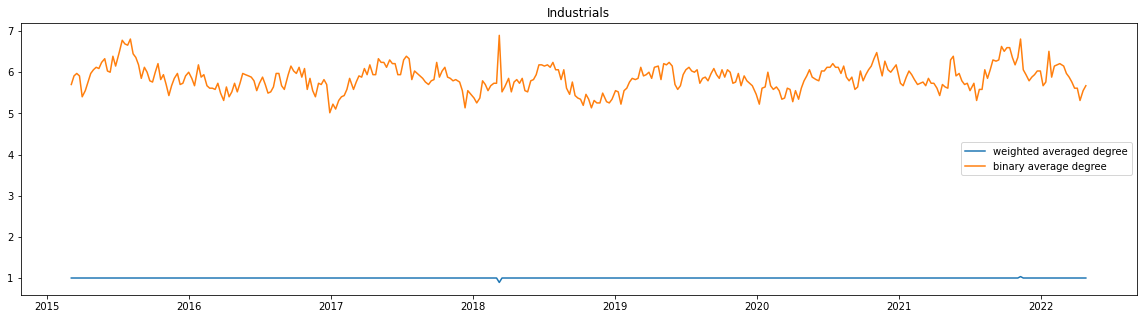

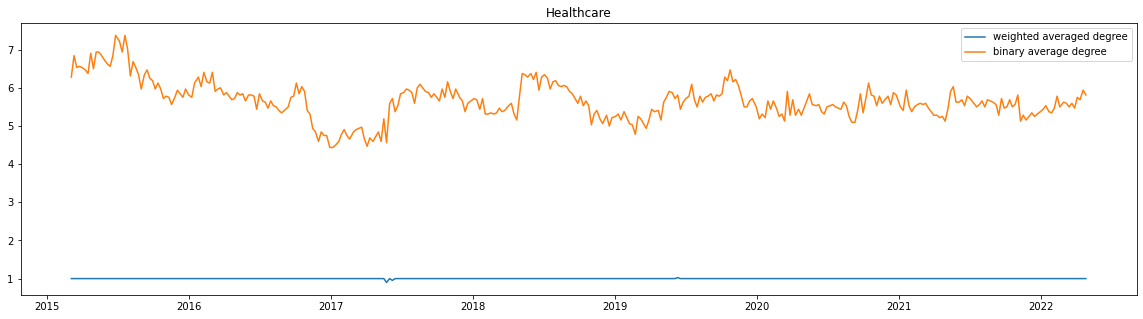

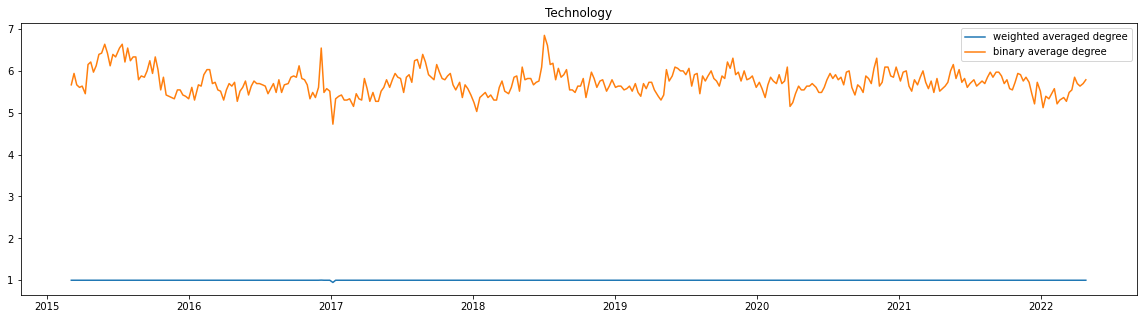

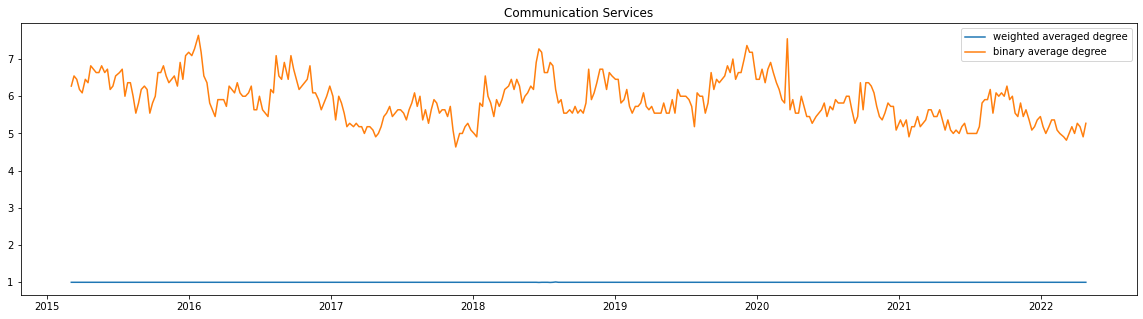

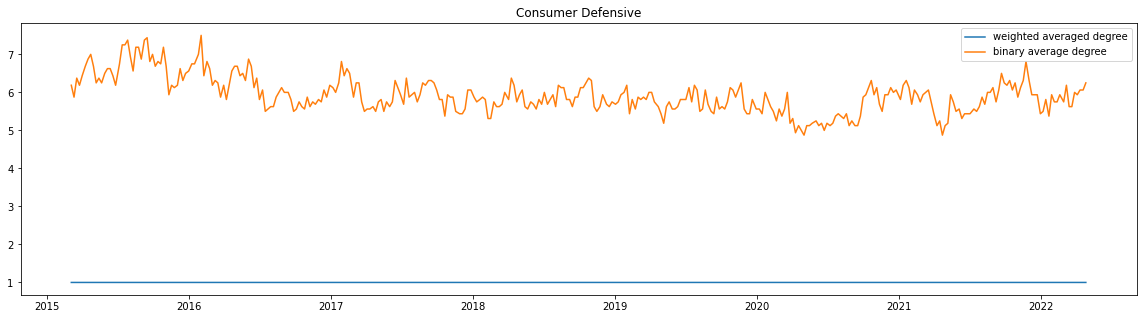

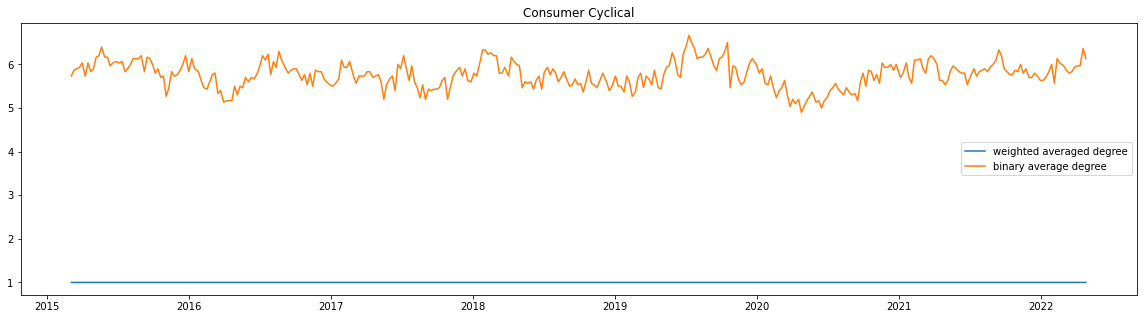

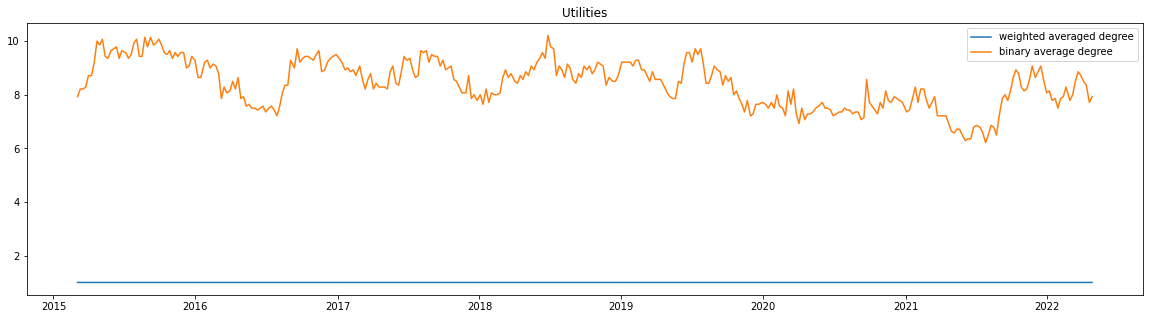

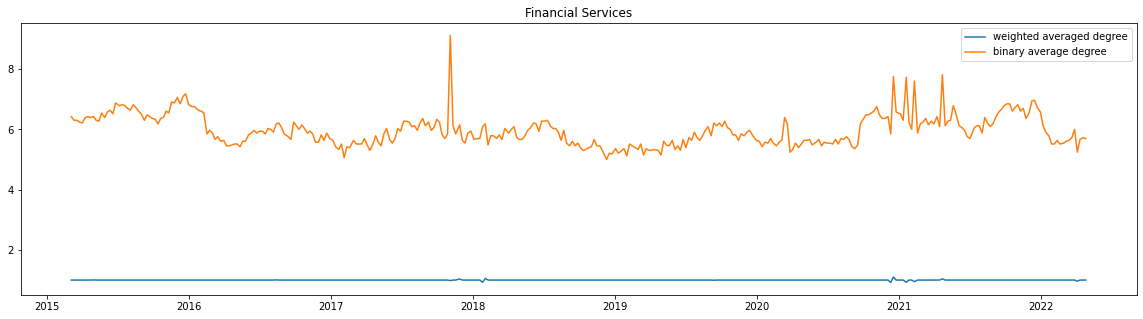

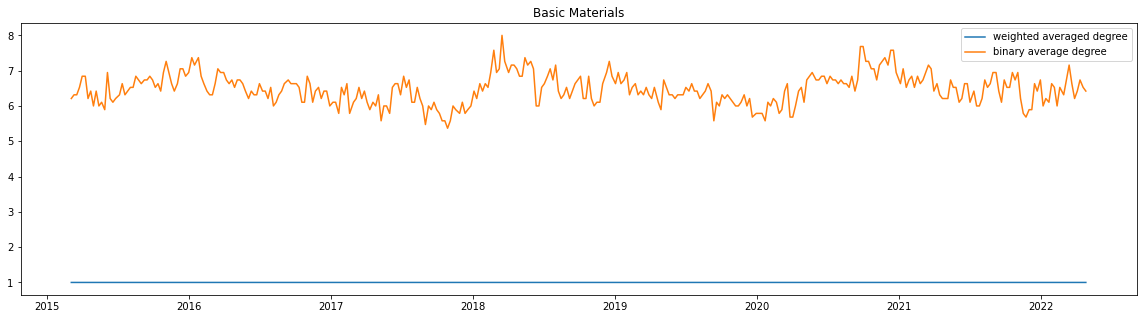

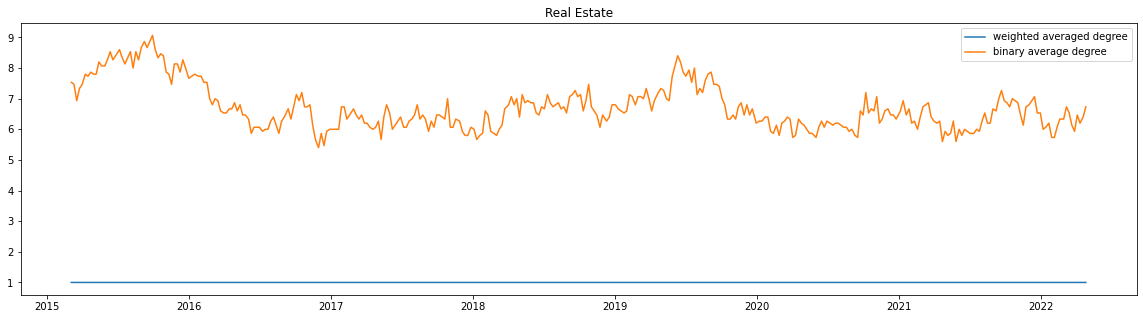

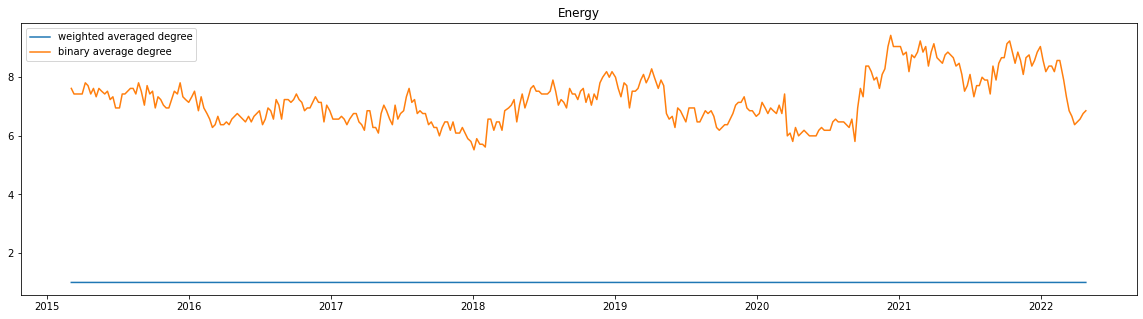

In [84]:

for k in sector_classification.keys():
    fig ,ax = plt.subplots(1,1, figsize = (20,5))

    ax.plot(dates3, gf.avg_degree_list(graphs[k],  weight = 'weight'), label = 'weighted averaged degree')
    ax.plot(dates3,gf.avg_degree_list(graphs[k]), label = 'binary average degree')
    ax.legend()
    ax.set_title(k)

In [99]:
covid_date = datetime.date(2020,3,11)
date_max_before_covid = np.max(np.where(dates3 < covid_date))

offset = 30
before_range = list(range((date_max_before_covid-offset),date_max_before_covid))
after_range = list(range(date_max_before_covid,(date_max_before_covid+offset)))

Gs = dict()
for k in sector_classification.keys():
    Gs_before = [graphs[k][i] for i in (before_range)]
    Gs_after = [graphs[k][i] for i in (after_range)]


    dates_before = dates3[before_range]
    dates_after = dates3[after_range]


    assert len(Gs_before) == len(Gs_after)

    Gs[k] = Gs_before + Gs_after

    n = len(Gs_before)
    m = len(Gs_after)

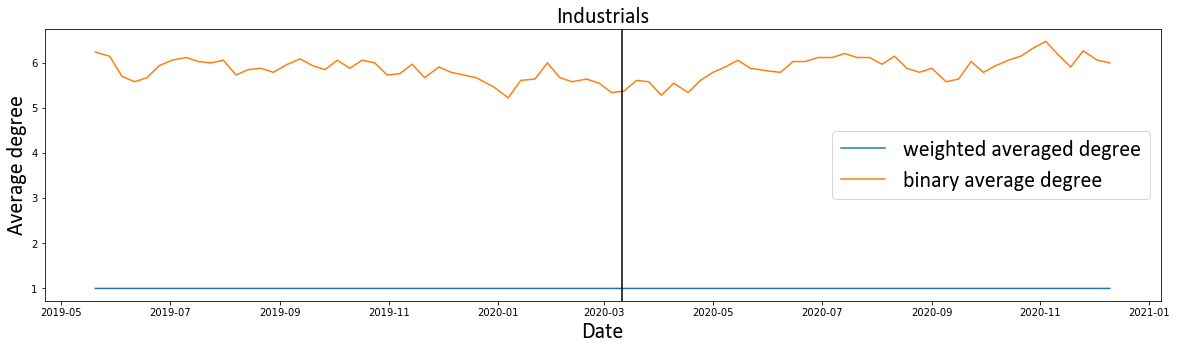

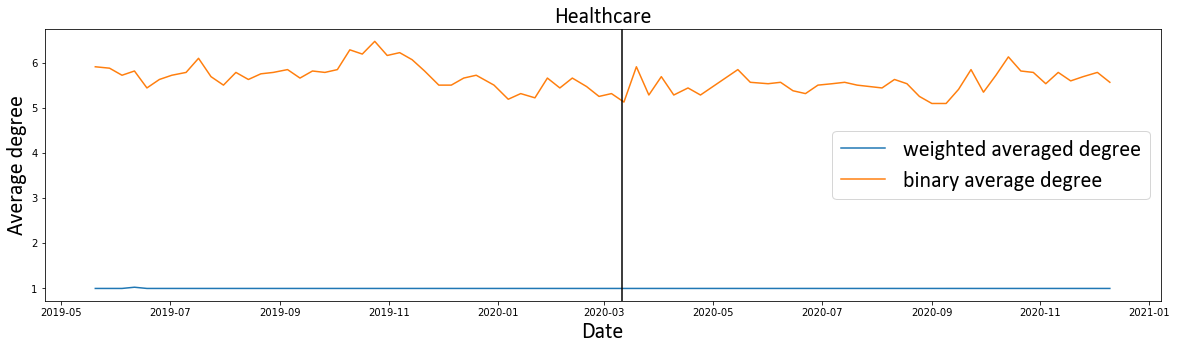

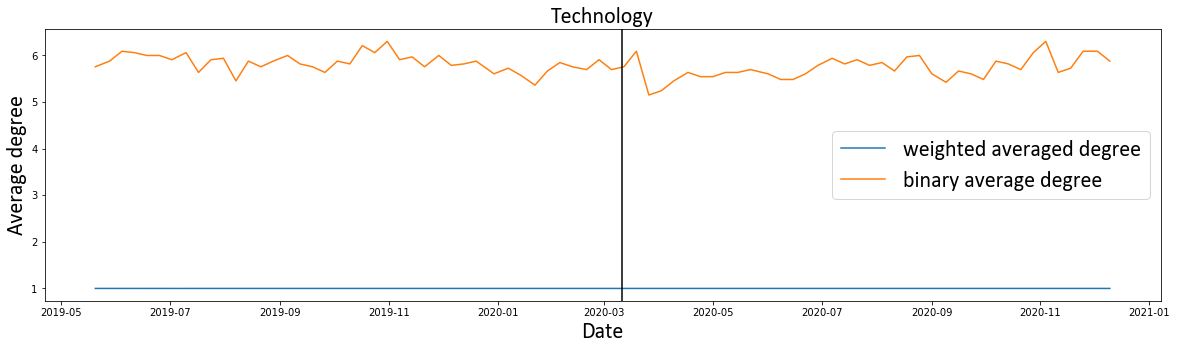

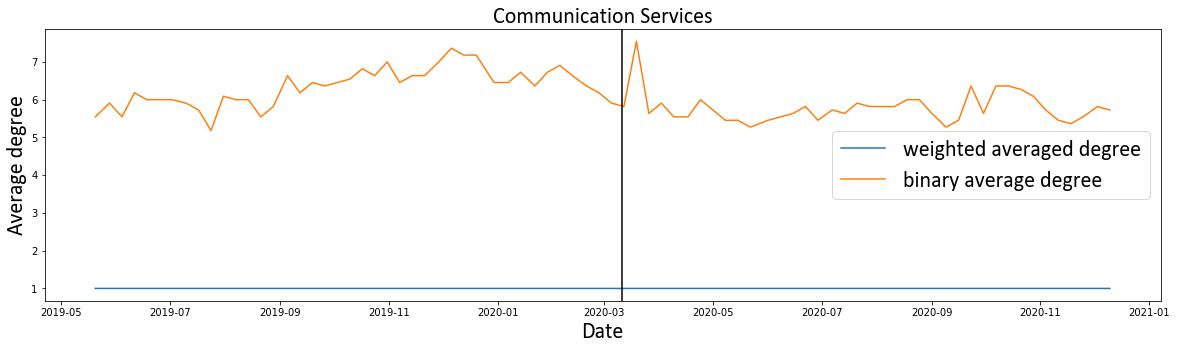

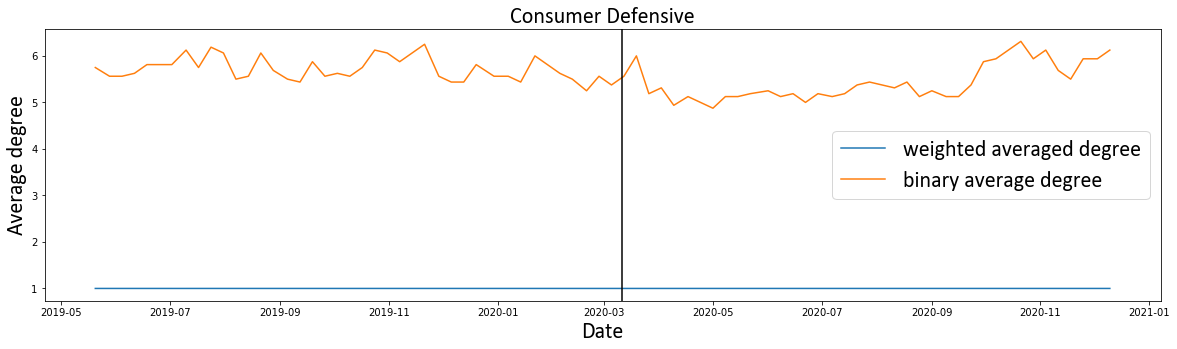

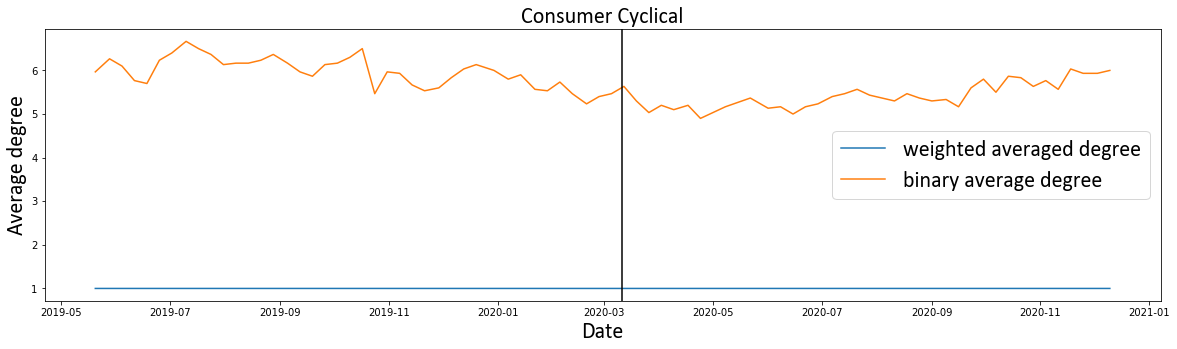

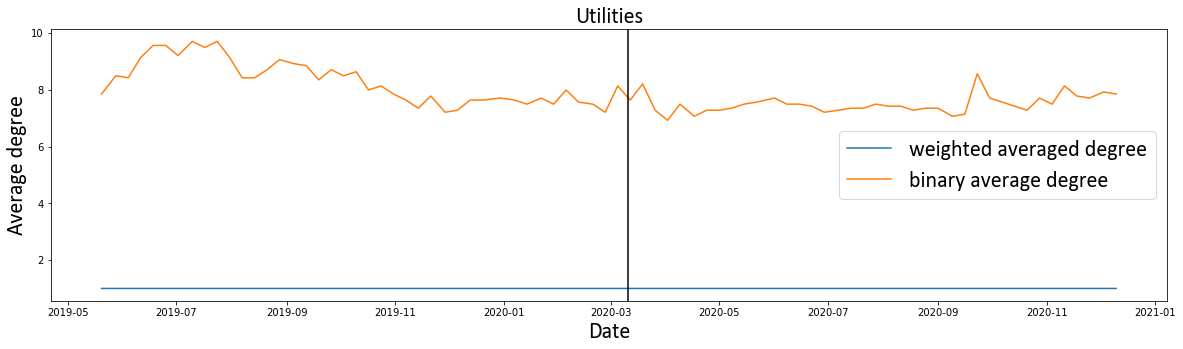

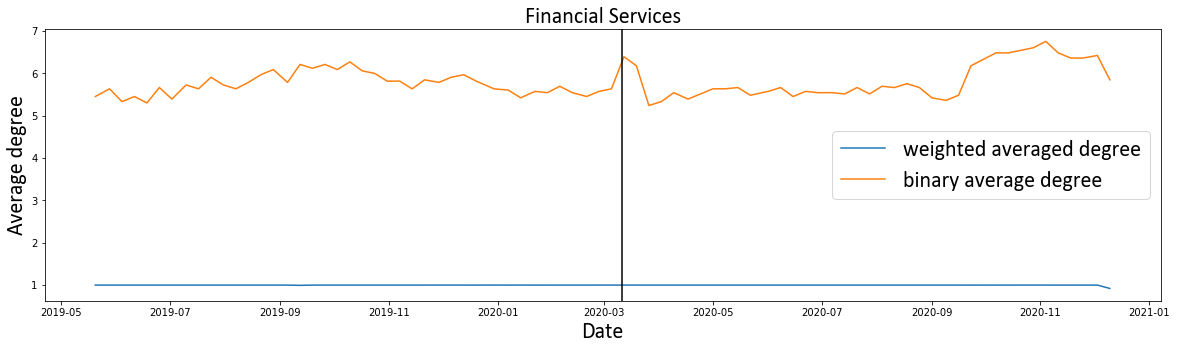

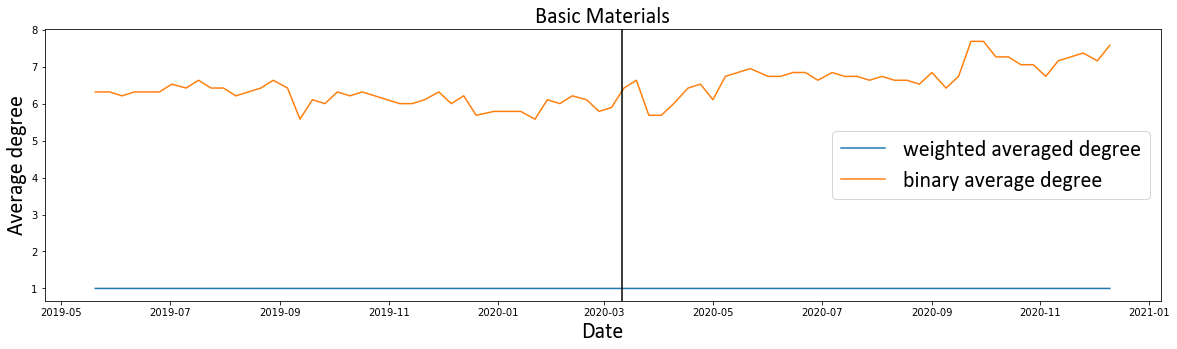

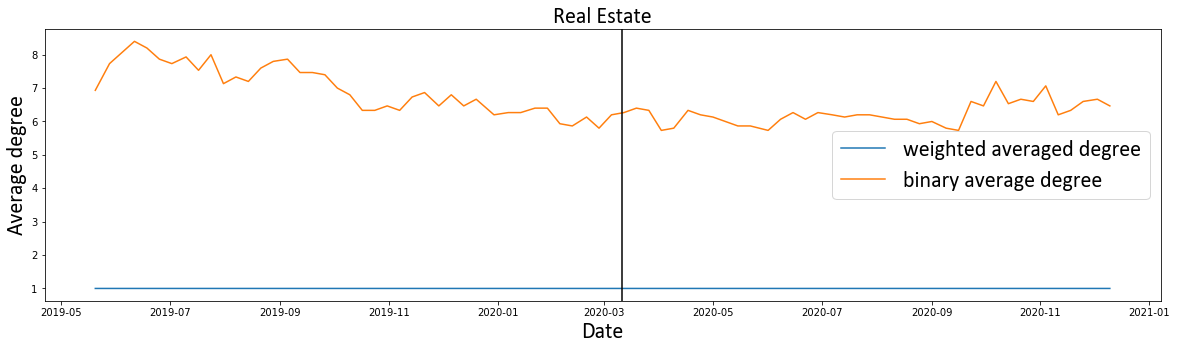

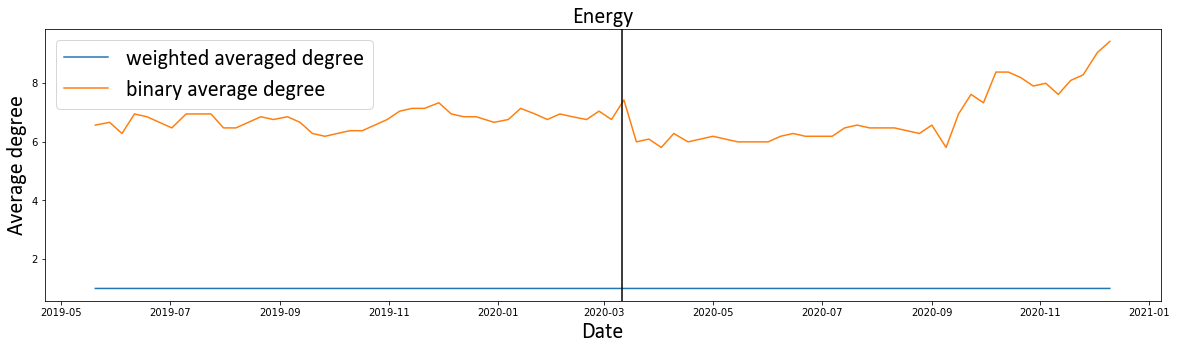

In [98]:
import matplotlib.font_manager as font_manager
covid_date = datetime.date(2020,3,11)

for k in sector_classification.keys():
    fig ,ax = plt.subplots(1,1, figsize = (20,5))

    axis_font = {'fontname':'Calibri', 'size':'22'}
    font_prop = font_manager.FontProperties(family="Calibri", size=22)
    ax.plot(dates3[before_range + after_range], gf.avg_degree_list([graphs[k][i] for i in before_range + after_range],  weight = 'weight'), label = 'weighted averaged degree')
    ax.plot(dates3[before_range + after_range],gf.avg_degree_list([graphs[k][i] for i in before_range + after_range]), label = 'binary average degree')
    ax.axvline(x = covid_date, color = 'black')
    ax.legend(prop = font_prop)
    ax.set_title(k, **axis_font)
    ax.set_ylabel("Average degree", **axis_font)
    ax.set_xlabel("Date", **axis_font)

In [104]:
for k in sector_classification.keys():
    G_data_sector = Gs[k]
    # label_list = np.unique(np.concatenate(label_list))
    rw_kernel = rw.RandomWalk(G_data_sector, c = 0.0001, normalize=0)
    # K = rw_kernel.fit_ARKL(r = 8, label_list = label_list, normalize_adj=True)
    # K = rw_kernel.fit_ARKU_plus(r = 6, normalize_adj=False, verbose=True, edge_attr = None)
    #K = rw_kernel.fit_random_walk(mu_vec=[0.0, 1.0/(nnode_1*nnode_2)], k = 1, r = 3, normalize_adj=False ) # 1/((nnode_1-1)*(nnode_2-1)))

    graph_list = gk.graph_from_networkx(G_data_sector, node_labels_tag='label')  # Convert to graphs to Grakel format
    # kernel = [{"name": "multiscale_laplacian"}]
    # K = mg.KernelMatrix(graph_list, kernel, False)   
    #kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "vertex_histogram"}]
    # kernel = [{"name": "WL-OA", "n_iter": 1}]
    kernel = [{"name": "SP", "with_labels": 0}]
    # kernel = [{"name": "lovasz_theta", "n_samples":20}]
    #kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
    # kernel = [{"name": "pyramid_match", "with_labels":False, "d":2, "L":4}] 
    #kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.1, 'with_labels':False, 'p':3}]
    # kernel = [{"name":'odd_sth', 'h':3}]
    #kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "propagation", "t_max": 2, "w":0.01, "M":'TV'}]

    init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
    K = init_kernel.fit_transform(graph_list)

    #kernel = WWL.WWL(param = {'discount':0.1,'h':1, 'sinkhorn':False })
    #K = kernel.fit_transform(G_data_sector)

    v,_ = np.linalg.eigh(K)
    v[np.abs(v) < 10e-5] = 0
    assert np.all(v) >= 0, "Not psd"

    MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    function_arguments = [dict(n = n, m = m ), 
                        dict(n = n, m = m ),
                        dict(n = n, m = m )]#, 
                        #dict(Q = 11, y1 = Gs[:n], y2 = Gs[n:] )]
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000)



    # Run power
    #threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.05)
    #print(f'threshold {threshold}')
    #ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], threshold, n)
    #print(f'V {V}')
    #print(f'ratio {ratio}')

    print(f'{k}')
    print(f'p_value {kernel_hypothesis.p_values}')
    #print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

Industrials
p_value {'MMD_b': 0.0339, 'MMD_u': 0.0339, 'MMD_l': 0.0009}
Healthcare
p_value {'MMD_b': 0.0162, 'MMD_u': 0.0162, 'MMD_l': 0.257}
Technology
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0001}
Communication Services
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0}
Consumer Defensive
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0}
Consumer Cyclical
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0}
Utilities
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0}
Financial Services
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0}
Basic Materials
p_value {'MMD_b': 0.0001, 'MMD_u': 0.0001, 'MMD_l': 0.0}
Real Estate
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0}
Energy
p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0}


<AxesSubplot:>

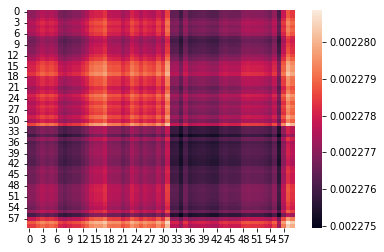

In [102]:
sns.heatmap(K)

# Sector graphs into ESG rating classes

In [259]:

def tlasso(X, rho, nu):

    from scipy.spatial import distance
    from sklearn.covariance import graphical_lasso


    p = X.shape[1]
    mu_0 = np.zeros(p)
    Phi_0 = np.identity(p)
    tau_0 = np.zeros(X.shape[0])
    
    for i in range(100):

        for j in range(X.shape[0]):
            tau_0[j] = (nu + p)/(nu + distance.mahalanobis(X[j,:], mu_0, Phi_0))

        tau_0_sum = np.sum(tau_0)

        mu_1 = np.zeros(p)

        for j in range(X.shape[0]):
            mu_1 += X[j,:]*tau_0[j]/tau_0_sum

        S_tau = np.identity(p)

        for j in range(X.shape[0]):

            S_tau += np.outer(X[j,:] - mu_1,X[j,:] - mu_1)*tau_0[j]/float(X.shape[0])

        out = graphical_lasso(S_tau, alpha = rho)


        Phi_1 = out[1]

        if np.linalg.norm(Phi_1 -Phi_0, ord = 'fro' ) <= 1e-6:
            Phi_0 = Phi_1
            mu_0 = mu_1
            break

        Phi_0 = Phi_1.copy()
        mu_0 = mu_1.copy()


    return Phi_0, mu_0, tau_0



def log_lik_t(X, loc, shape_inv , df, rho ):
    from scipy.stats import multivariate_t

    s = 0.0
    shape= np.linalg.inv(shape_inv)
    for j in range(X.shape[0]):

        s+= multivariate_t.logpdf(X[j, ], loc = loc, shape = shape, df = df)

    s - rho*np.sum(np.abs(shape_inv))/2 +rho*np.sum(np.diag(np.abs(shape_inv)))/2

    return s




def tlasso_cv(X, rho_grid, nr_cv):


    X_splits = np.array_split(X, nr_cv)
    out_fit_mvt = fitHeavyTail.fit_mvt(X,nu="MLE-diag-resample")
    out_fit_mvt = dict(zip(out_fit_mvt.names, list(out_fit_mvt)))

    nu = out_fit_mvt['nu']

    df = pd.DataFrame()

    for rho in rho_grid:
        info_dict = dict()
        info_dict['rho'] = rho
        info_dict['avg_log_lik'] = 0

        for i, X_split in enumerate(X_splits):

            phi, mu, tau_0 = tlasso(X_split, rho, nu )

            X_test = np.vstack([X_splits[j] for j in range(nr_cv) if j!=i])

            info_dict['avg_log_lik'] +=  log_lik_t(X_test, mu, phi, nu, rho)/nr_cv

        df = pd.concat((df, pd.DataFrame(info_dict, index = [0])), ignore_index=True)

        best_rho = df['rho'].loc[df['avg_log_lik'] == np.max(df['avg_log_lik'])].iloc[0]
        phi_best, mu_best, tau_0 = tlasso(X, best_rho, nu )

    
    return df, phi_best, mu_best, best_rho


df, phi_best, mu_best, best_rho = tlasso_cv(np.array(price_pivot.iloc[:100, 100:120]), [0,0.0001/100, 0.0005/100,  0.1/100], 2)


In [268]:
def gen_theta(k, sparsity, seed):
    np.random.seed(seed=seed)
    # generate the symmetric sparsity mask
    mask = np.random.uniform(size = k)
    mask = mask * (mask < sparsity)
    mask = np.triu(mask)
    mask = mask + mask.T + np.identity(k)
    mask[mask > 0] = 1

    # generate the symmetric precision matrix
    theta = np.random.normal(size = (k,k))
    theta = np.random.normal(size = (k,k))
    theta = np.triu(theta)
    theta = theta + theta.T + np.identity(k)

    # apply the reqired sparsity
    theta = theta * mask

    l, _ = np.linalg.eigh(theta)
    # force it to be positive definite
    theta = theta - (np.min(l)-.1) * np.identity(k)

    return theta


theta = gen_theta(5, 0.3, 42)

from scipy.stats import multivariate_t
Y = multivariate_t.rvs(loc = np.zeros(5), shape = np.linalg.inv(theta), df = 3.2, size = 100)
out_fit_mvt = fitHeavyTail.fit_mvt(Y,nu="MLE-diag-resample")
out_fit_mvt = dict(zip(out_fit_mvt.names, list(out_fit_mvt)))

nu = out_fit_mvt['nu']


phi_best, mu_best, tau = tlasso(Y, 0.2, 3.2)



In [188]:
from sklearn.covariance import GraphicalLassoCV
out = GraphicalLassoCV()
out.fit(np.array(price_pivot.iloc[:100, :20]))

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV()

In [6]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
spectralGraphTopology = importr('spectralGraphTopology')
igraph = importr('igraph')
fingraph = importr('fingraph')
fitHeavyTail = importr('fitHeavyTail')


Unable to determine R library path: Command '('C:\\PROGRA~1\\R\\R-41~1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [7]:
esg_refined_monthly = esg_refined.loc[esg_refined.index == np.array([d.replace(day=1) for d in esg_refined.index])]
esg_refined_monthly = esg_refined_monthly.fillna(method = 'ffill')
stocks_considered= dict()

nr_splits = 3 
days_from_i = 50

graph_dict = {i: {k:[] for k in sector_classification.keys()} for i in range(nr_splits)}

dates4 = {k:[] for k in sector_classification.keys()} 


for i in tqdm.tqdm(range(4, esg_refined_monthly.shape[0])):
    

    for k in sector_classification.keys():

        if stocks_considered.get(k,None) is None:
            stocks_in_sector = price_pivot.columns[np.isin(price_pivot.columns,sector_classification[k])]
            esg_stocks_in_sector = esg_refined.columns[np.isin(esg_refined.columns,sector_classification[k])]

            stocks_considered[k] = stocks_in_sector.intersection(esg_stocks_in_sector)
            print(f'{k} has {len(stocks_considered[k])} stocks')
            

            if len(stocks_considered[k]) % nr_splits != 0:
                res = len(stocks_considered[k]) % nr_splits
                print(f'{k} dropped a stock {stocks_considered[k][:res]}')
                stocks_considered[k] = stocks_considered[k][res:]


        esg_i = np.array(esg_refined_monthly[stocks_considered[k]].iloc[i])

        stocks_ordered_i = np.array(stocks_considered[k][np.argsort(esg_i)])

        date_i = esg_refined_monthly.index[i]
        day_range_from_i = np.array([date_i - datetime.timedelta(days=i) for i in range(days_from_i)])
        dates4[k].append(date_i)

        stocks_indexes = np.array(range(len(stocks_considered[k])))
        for i_split, stocks_index in enumerate(np.array_split(stocks_indexes, nr_splits)):


            stock_split_i = price_pivot[stocks_ordered_i[stocks_index]].loc[np.isin(price_pivot.index, day_range_from_i)]

            try:
                scaler = StandardScaler()
                X = scaler.fit_transform(stock_split_i)
                out_fit_mvt = fitHeavyTail.fit_mvt(X,nu="MLE-diag-resample")
                out_fit_mvt = dict(zip(out_fit_mvt.names, list(out_fit_mvt)))
                out_fingraph = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = out_fit_mvt['nu'])
                out_fingraph = dict(zip(out_fingraph.names, list(out_fingraph)))
                G = nx.from_numpy_array(out_fingraph['adjacency'])
            except:
                # remove all graphs from if there is a graph estimation failure
                for remove_i in range(i_split):
                    graph_dict[remove_i][k].pop(-1)
                dates4[k].pop(-1)
                break
            
            graph_dict[i_split][k].append(G)



for k in sector_classification.keys():
    dates4[k] = np.array(dates4[k])


  0%|          | 0/85 [00:00<?, ?it/s]

Industrials has 60 stocks
Healthcare has 55 stocks
Healthcare dropped a stock Index(['LH'], dtype='object')
Technology has 57 stocks
Communication Services has 16 stocks
Communication Services dropped a stock Index(['TMUS'], dtype='object')
Consumer Defensive has 32 stocks
Consumer Defensive dropped a stock Index(['KMB', 'DLTR'], dtype='object')
Consumer Cyclical has 56 stocks
Consumer Cyclical dropped a stock Index(['BWA', 'GM'], dtype='object')
Utilities has 27 stocks
Financial Services has 62 stocks
Financial Services dropped a stock Index(['USB', 'BLK'], dtype='object')
Basic Materials has 17 stocks
Basic Materials dropped a stock Index(['PPG', 'FMC'], dtype='object')
Real Estate has 29 stocks
Real Estate dropped a stock Index(['DRE', 'MAA'], dtype='object')
Energy has 18 stocks


 40%|████      | 34/85 [03:50<05:42,  6.71s/it]R[write to console]: Error in eigen(rho * (Lwi + J) - Y, symmetric = TRUE) : 
  infinite or missing values in 'x'

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

 92%|█████████▏| 78/85 [09:17<00:51,  7.39s/it]R[write to console]: Error in eigen(rho * (Lwi + J) - Y, symmetric = TRUE) : 
  infinite or missing values in 'x'

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

100%|██████████| 85/85 [10:09<00:00,  7.17s/it]


In [37]:
# import pickle
# graph_obj = dict()
# graph_obj['graphs'] = graph_dict
# graph_obj['dates'] = dates4

# with open('../data/paper/esg_split_3_30months.pkl', 'wb') as handle:
#     pickle.dump(graph_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
dates4

{'Industrials': array([datetime.date(2015, 2, 1), datetime.date(2015, 3, 1),
        datetime.date(2015, 4, 1), datetime.date(2015, 5, 1),
        datetime.date(2015, 6, 1), datetime.date(2015, 7, 1),
        datetime.date(2015, 8, 1), datetime.date(2015, 9, 1),
        datetime.date(2015, 10, 1), datetime.date(2015, 11, 1),
        datetime.date(2015, 12, 1), datetime.date(2016, 1, 1),
        datetime.date(2016, 2, 1), datetime.date(2016, 3, 1),
        datetime.date(2016, 4, 1), datetime.date(2016, 5, 1),
        datetime.date(2016, 6, 1), datetime.date(2016, 7, 1),
        datetime.date(2016, 8, 1), datetime.date(2016, 9, 1),
        datetime.date(2016, 10, 1), datetime.date(2016, 11, 1),
        datetime.date(2016, 12, 1), datetime.date(2017, 1, 1),
        datetime.date(2017, 2, 1), datetime.date(2017, 3, 1),
        datetime.date(2017, 4, 1), datetime.date(2017, 5, 1),
        datetime.date(2017, 6, 1), datetime.date(2017, 7, 1),
        datetime.date(2017, 8, 1), datetime.date(

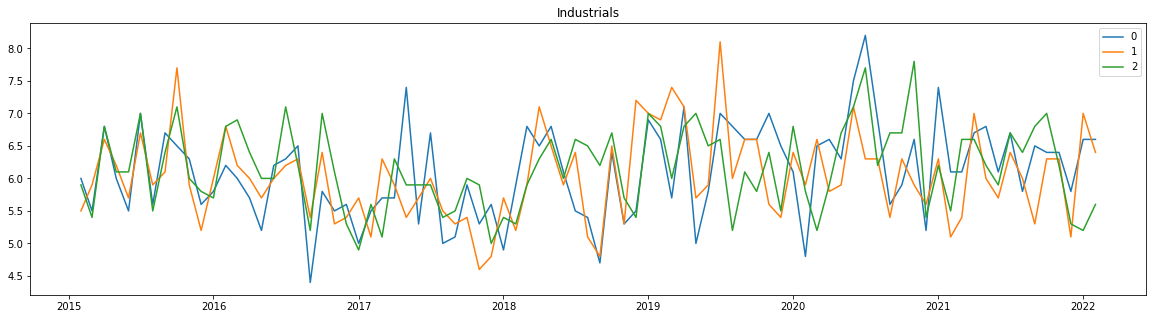

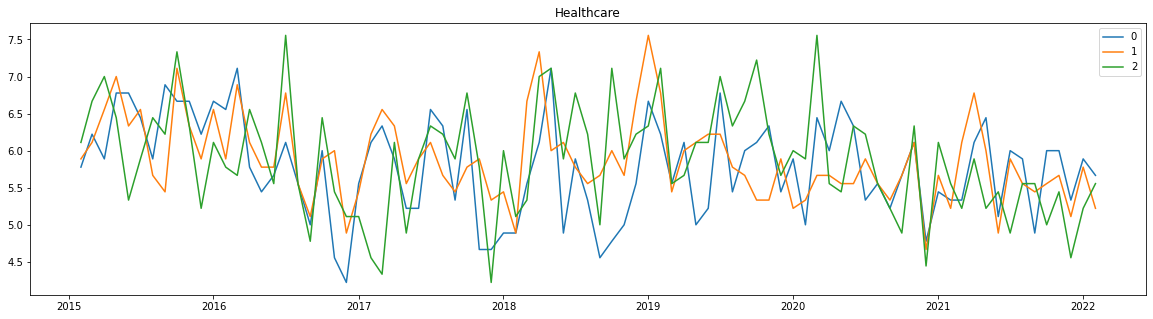

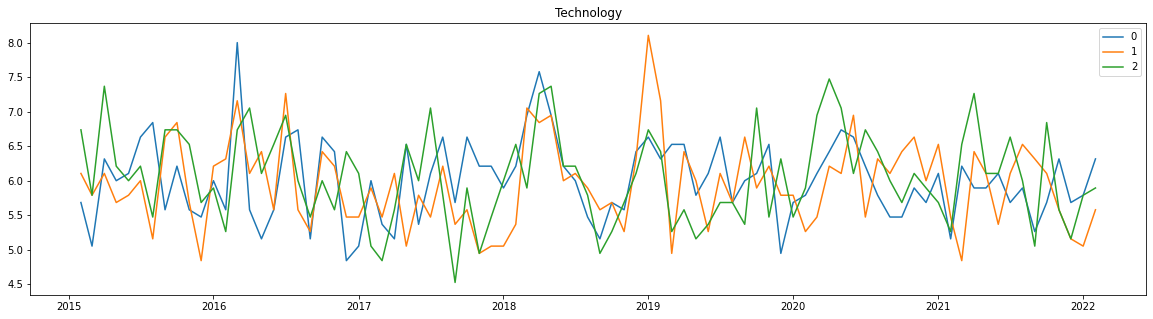

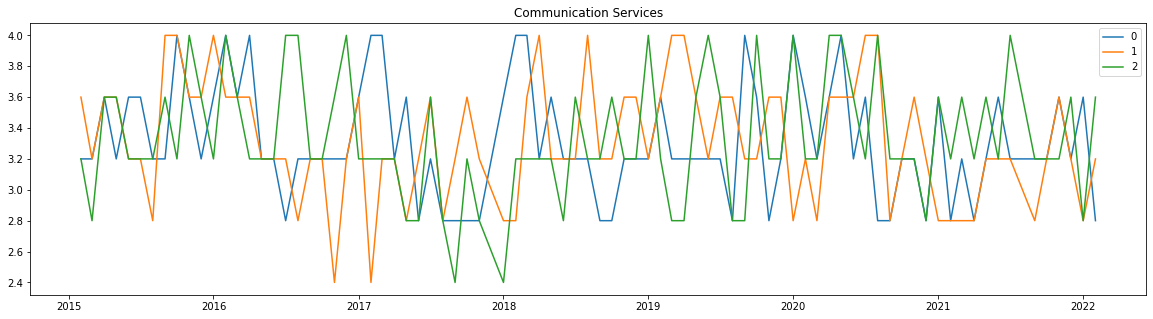

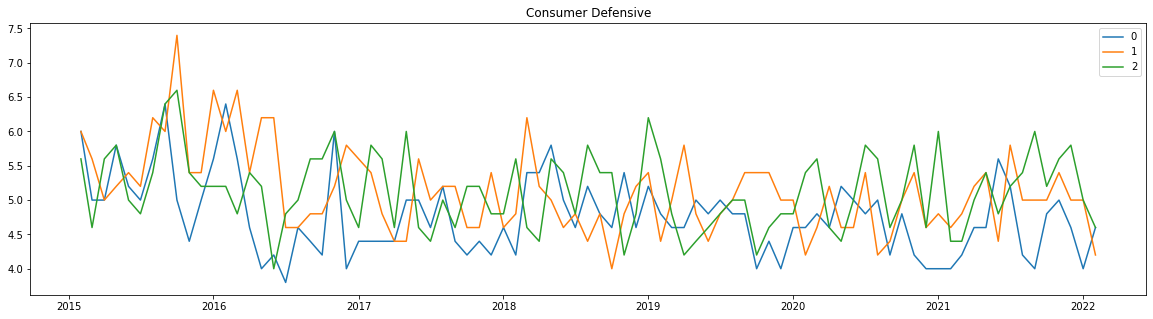

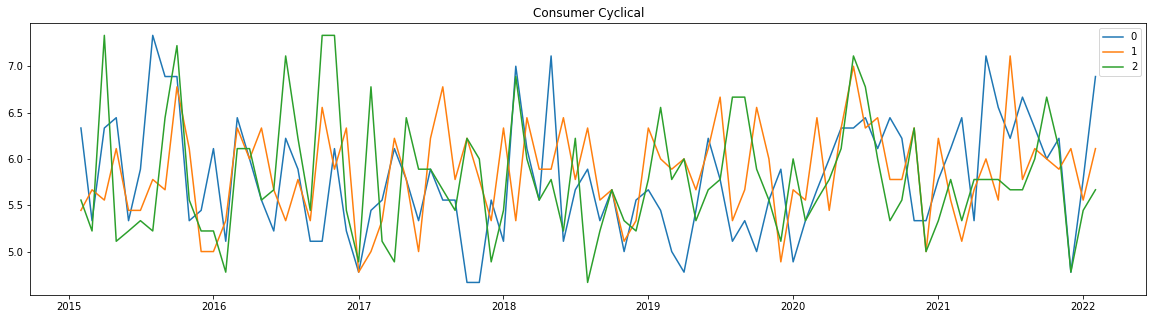

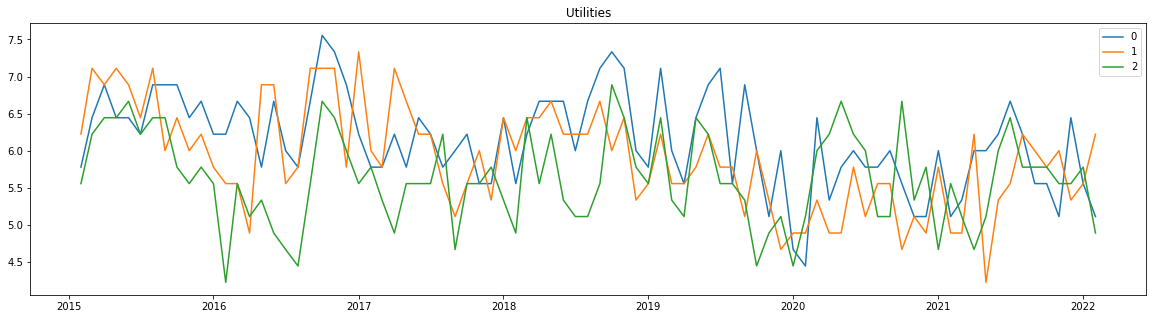

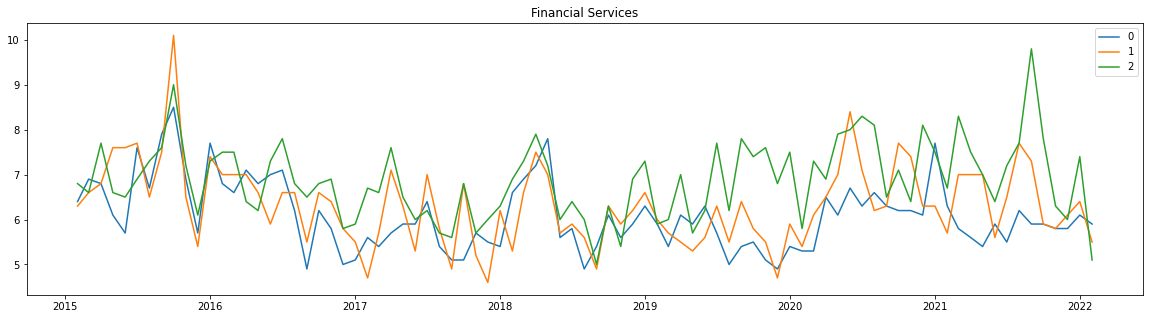

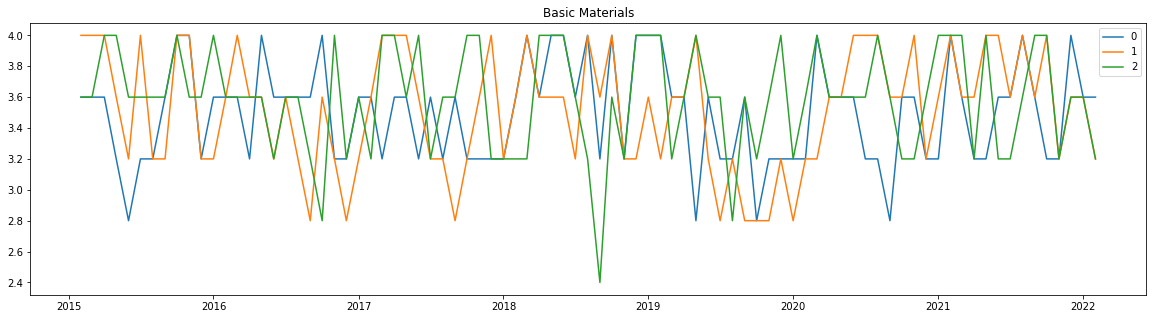

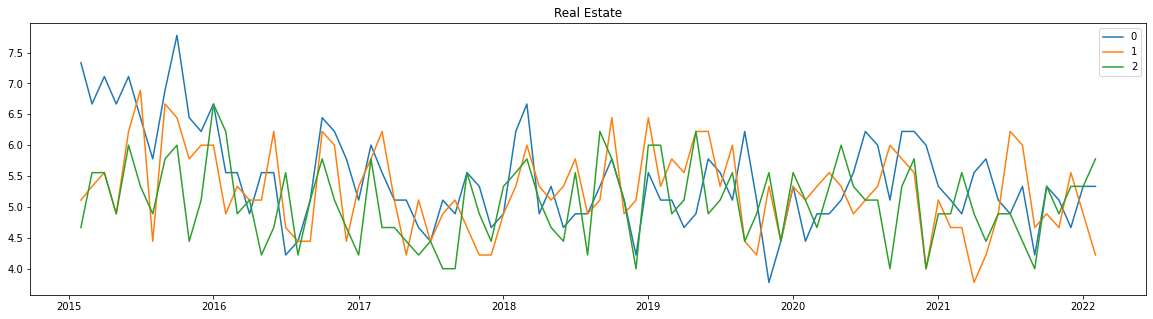

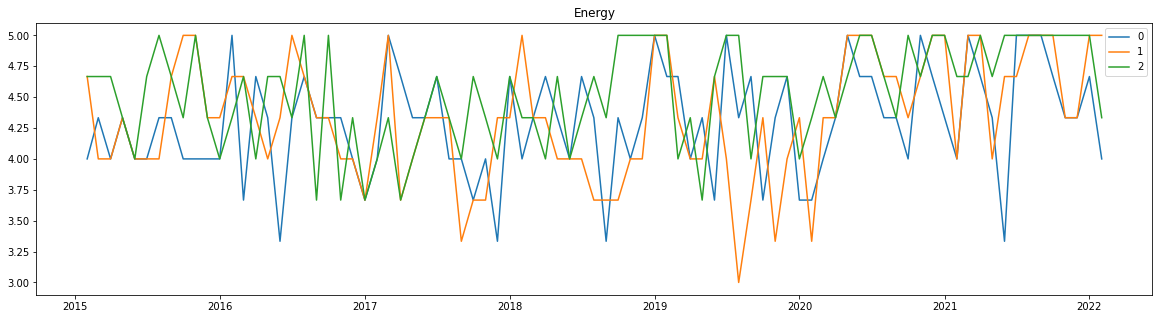

In [8]:
for k in sector_classification.keys():
    fig ,ax = plt.subplots(1,1, figsize = (20,5))

    for i in range(len(graph_dict)):
        ax.plot(dates4[k], gf.avg_degree_list(graph_dict[i][k]), label = str(i))
    ax.legend()
    ax.set_title(k)

RW kernel no weights

In [53]:
mmd_i = {k:[] for k in sector_classification.keys()}
n = 30
m = n

esg_return_df = pd.DataFrame()

for k in sector_classification.keys():
    for group_1 in range(len(graph_dict)):
        for group_2 in range(group_1+1, len(graph_dict)):
            for cnt, i in tqdm.tqdm(enumerate(range(n, len(graph_dict[group_1][k])))):
                # print(i-cnt)

                G_data_sector = [ graph_dict[group_1][k][s] for s in range(cnt, i )] + [ graph_dict[group_2][k][s] for s in range(cnt, i )]
                calc_ok = True
                for c in [0.001, 0.0001, 0.00001, 0.000001]:

                    r = np.min((6, G_data_sector[0].number_of_nodes()-1))
                    rw_kernel = rw.RandomWalk(G_data_sector, c = 0.0001, normalize=0)
                    K = rw_kernel.fit_ARKU_plus(r = r, normalize_adj=False, verbose=False, edge_attr = None)

                    v,_ = np.linalg.eigh(K)
                    v[np.abs(v) < 10e-5] = 0
                    if np.all(v) >= 0:
                        calc_ok = True
                        break
                    calc_ok = False

                if calc_ok != True:
                    assert False, "Kernel not psd"



                MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
                kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
                function_arguments = [dict(n = n, m = m ), 
                                    dict(n = n, m = m ),
                                    dict(n = n, m = m )]#, 
                                    #dict(Q = 11, y1 = Gs[:n], y2 = Gs[n:] )]
                kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000)

                info_dict = dict()
                info_dict['sector'] = k
                info_dict['group_i'] = group_1
                info_dict['group_j'] = group_2
                info_dict['MMD_u'] = kernel_hypothesis.p_values['MMD_u']
                info_dict['MMD_b'] = kernel_hypothesis.p_values['MMD_b']
                info_dict['MMD_l'] = kernel_hypothesis.p_values['MMD_l']
                info_dict['dates'] = dates4[k][i]

                esg_return_df = pd.concat((esg_return_df, pd.DataFrame(info_dict, index = [0])), ignore_index=True)


0it [00:00, ?it/s]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
1it [00:01,  1.51s/it]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
2it [00:03,  1.51s/it]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
3it [00:04,  1.50s/it]C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 

C:\Users\User\AppData\Local\Temp\ipykernel_2696\3603417291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['id'] = tmp['group_i'].astype(str) + tmp['group_j'].astype(str)
C:\Users\User\AppData\Local\Temp\ipykernel_2696\3603417291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['id'] = tmp['group_i'].astype(str) + tmp['group_j'].astype(str)
C:\Users\User\AppData\Local\Temp\ipykernel_2696\3603417291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

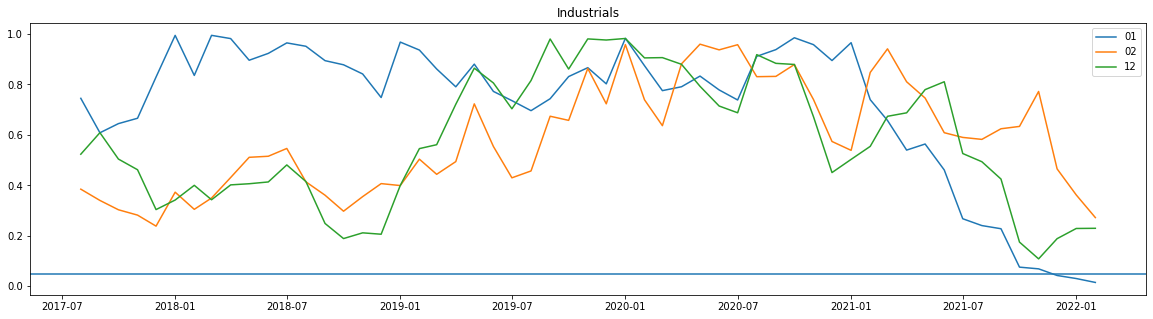

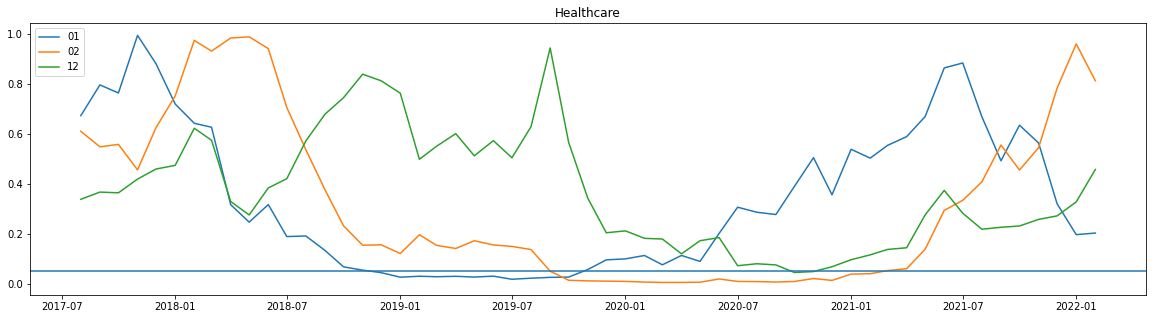

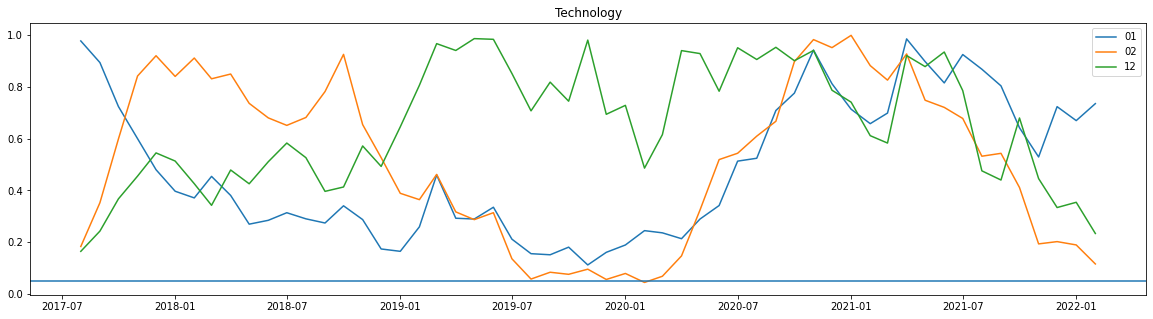

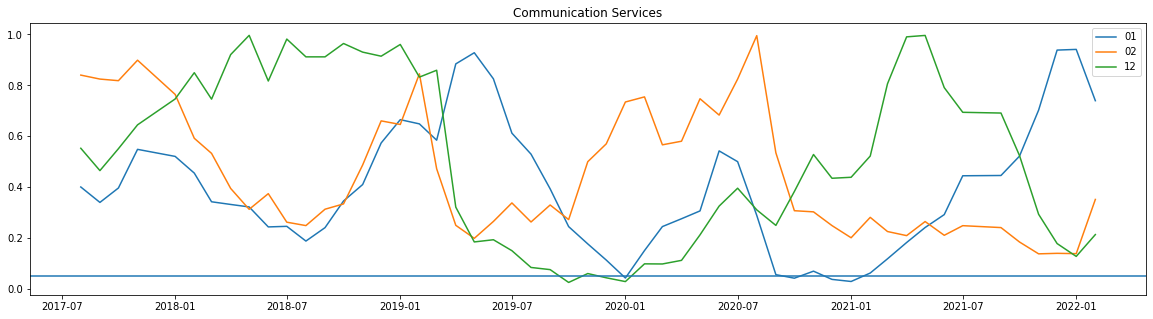

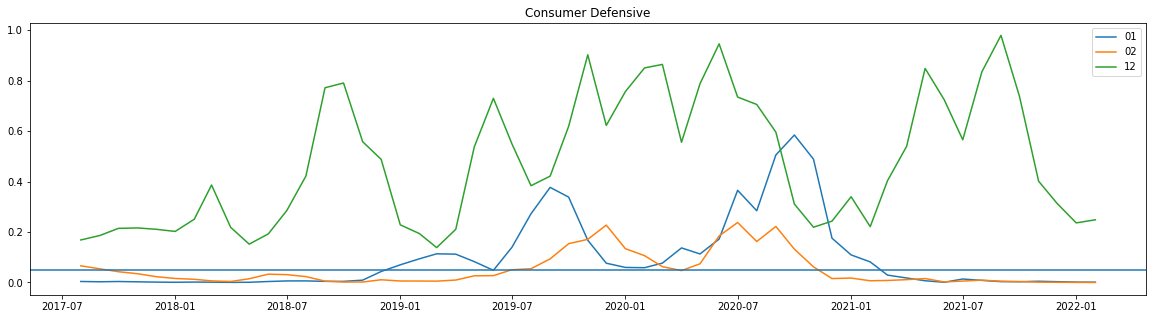

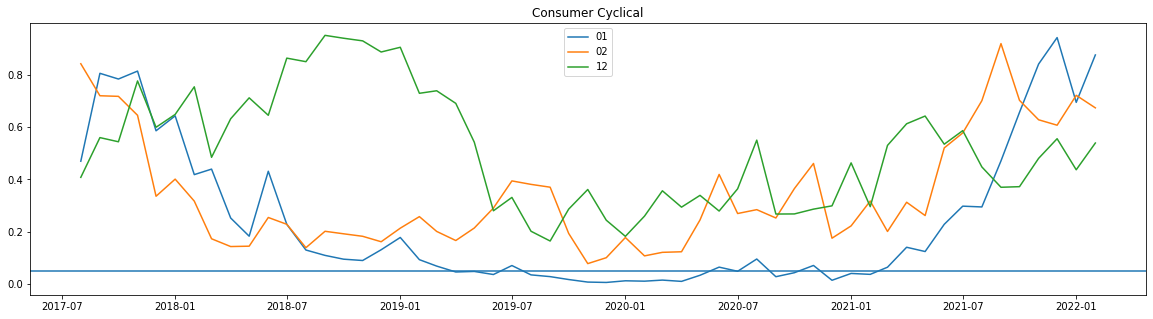

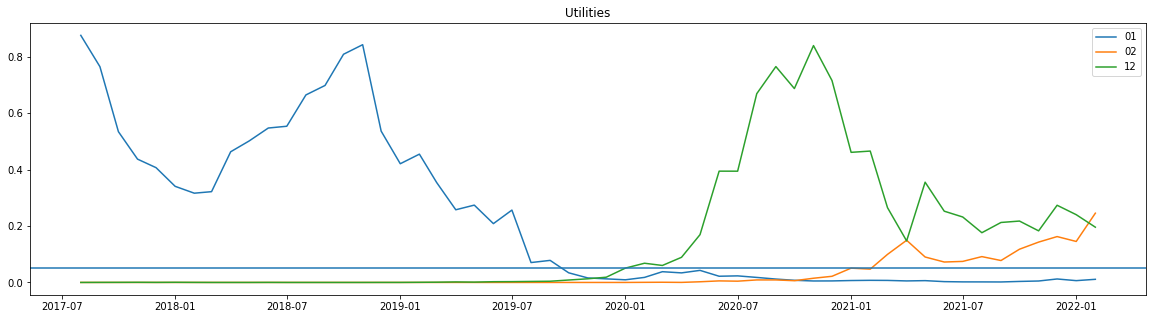

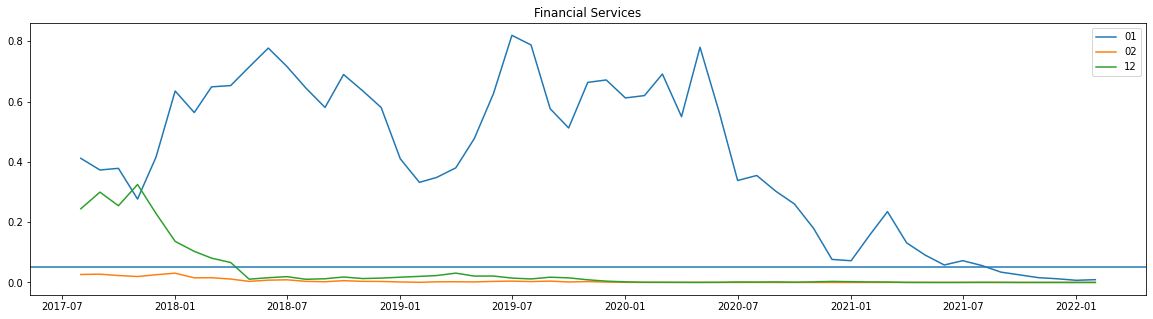

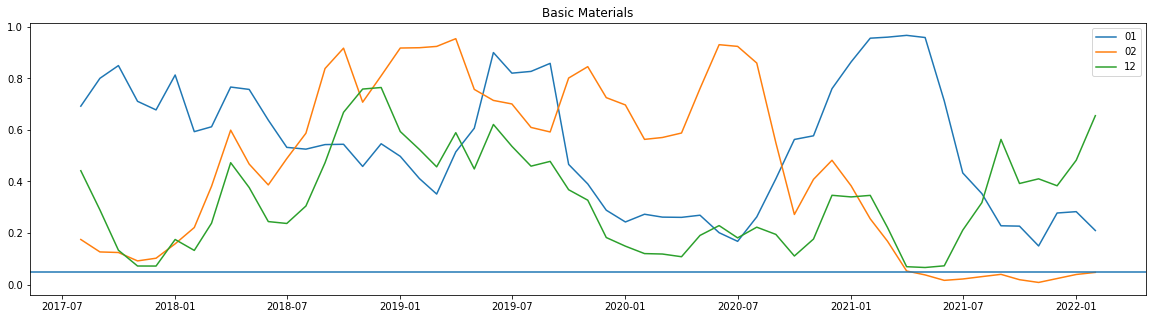

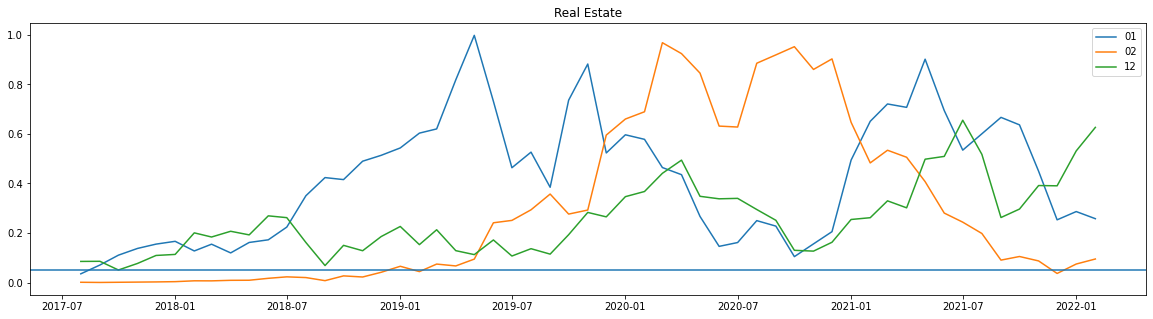

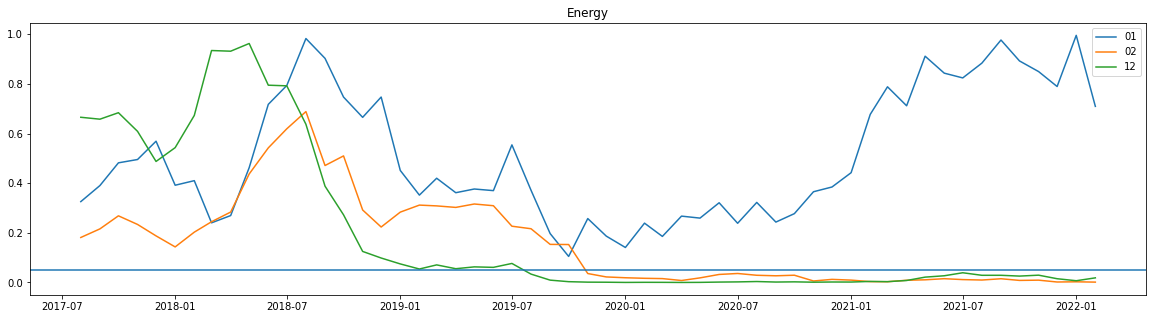

In [54]:
for k in sector_classification.keys():
    fig ,ax = plt.subplots(1,1, figsize = (20,5))

    tmp = esg_return_df.loc[esg_return_df['sector'] == k]
    tmp['id'] = tmp['group_i'].astype(str) + tmp['group_j'].astype(str) 
    for id in np.unique(tmp['id']):
        ax.plot(tmp['dates'].loc[tmp['id'] == id], tmp['MMD_u'].loc[tmp['id'] == id], label = id)
    ax.axhline(y = 0.05)
    ax.legend()
    ax.set_title(k)

RW kernel with weights

In [65]:
mmd_i = {k:[] for k in sector_classification.keys()}
n = 30
m = n

esg_return_df_rw_weight = pd.DataFrame()

for k in sector_classification.keys():
    for group_1 in range(len(graph_dict)):
        for group_2 in range(group_1+1, len(graph_dict)):
            pbar = tqdm.tqdm()
            for cnt, i in enumerate(range(n, len(graph_dict[group_1][k]))):
                # print(i-cnt)

                G_data_sector = [ graph_dict[group_1][k][s] for s in range(cnt, i )] + [ graph_dict[group_2][k][s] for s in range(cnt, i )]
                calc_ok = True
                for c in [0.001, 0.0001, 0.00001, 0.000001]:

                    r = np.min((6, G_data_sector[0].number_of_nodes()-1))
                    rw_kernel = rw.RandomWalk(G_data_sector, c = 0.0001, normalize=0)
                    K = rw_kernel.fit_ARKU_plus(r = r, normalize_adj=False, verbose=False, edge_attr = 'weight')

                    v,_ = np.linalg.eigh(K)
                    v[np.abs(v) < 10e-5] = 0
                    if np.all(v) >= 0:
                        calc_ok = True
                        break
                    calc_ok = False

                if calc_ok != True:
                    assert False, "Kernel not psd"



                MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
                kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
                function_arguments = [dict(n = n, m = m ), 
                                    dict(n = n, m = m ),
                                    dict(n = n, m = m )]#, 
                                    #dict(Q = 11, y1 = Gs[:n], y2 = Gs[n:] )]
                kernel_hypothesis.Bootstrap(K, function_arguments, B = 10000)

                info_dict = dict()
                info_dict['sector'] = k
                info_dict['group_i'] = group_1
                info_dict['group_j'] = group_2
                info_dict['MMD_u'] = kernel_hypothesis.p_values['MMD_u']
                info_dict['MMD_b'] = kernel_hypothesis.p_values['MMD_b']
                info_dict['MMD_l'] = kernel_hypothesis.p_values['MMD_l']
                info_dict['dates'] = dates4[k][i]

                esg_return_df_rw_weight = pd.concat((esg_return_df_rw_weight, pd.DataFrame(info_dict, index = [0])), ignore_index=True)
                pbar.update()

pbar.close()


C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
C:/Users/User/Code/MMDGraph\myKernels\RandomWalk.py:902: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.f

In [ ]:
for k in sector_classification.keys():
    fig ,ax = plt.subplots(1,1, figsize = (20,5))

    tmp = esg_return_df_rw_weight.loc[esg_return_df_rw_weight['sector'] == k]
    tmp['id'] = tmp['group_i'].astype(str) + tmp['group_j'].astype(str) 
    for id in np.unique(tmp['id']):
        ax.plot(tmp['dates'].loc[tmp['id'] == id], tmp['MMD_u'].loc[tmp['id'] == id], label = id)
    ax.axhline(y = 0.05)
    ax.legend()
    ax.set_title(k)